# Run 1peat tvc

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import calendar
import os

In [118]:
site = 'tvc'
site_longname = 'Trail Valley Creak, northwestern Canada'
y_start = 2013
y_end = 2019

labels = [
    '1peat_30min_ext', 
    # '1peat_DEF', 
    '1peat_BUG_CORRECT_TSNBT_OP1_EZERO',
    '1peat_PHYS_ALL_SUBLI_CORRECT',
    '1peat_PHYS_ALL_SUBLI_CORRECT_COMPAC',
    '1peat_PHYS_ALL_SUBLI_CORRECT_COMPAC_calonne',
]

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/'+site+'/'
paths = [root_path+'run_'+label for label in labels]

# ds_yr_list = [xr.open_mfdataset(path+'/*_annually.nc').squeeze().load() for path in paths]
# ds_mo_list = [xr.open_mfdataset(path+'/*_monthly.nc').squeeze().load() for path in paths]
ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
# ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [119]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowArctic/"+site
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_'+labels[0]+'.nc')

In [120]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [121]:
for i in range(len(labels)):
    # ds_yr_list[i] = assign_center_depth(ds_yr_list[i], rsfile)
    # ds_mo_list[i] = assign_center_depth(ds_mo_list[i], rsfile)
    ds_d_list[i] = assign_center_depth(ds_d_list[i], rsfile)
    # ds_hh_list[i] = assign_center_depth(ds_hh_list[i], rsfile)

In [122]:
ds_d_list[i]

<xarray.Dataset> Size: 3MB
Dimensions:     (time: 2555, layer: 20)
Coordinates:
  * time        (time) object 20kB 2013-01-01 00:00:00 ... 2019-12-31 00:00:00
  * layer       (layer) float64 160B 0.05 0.15 0.25 0.35 ... 8.9 18.9 41.4 58.9
Data variables: (12/54)
    longitude   float64 8B -133.5
    latitude    float64 8B 68.75
    actlyr      (time) float64 20kB 0.2817 0.2704 0.2602 0.2507 ... 0.0 0.0 0.0
    albs        (time) float64 20kB 0.708 0.7074 0.681 ... 0.4142 0.4921 0.4761
    albsir      (time) float64 20kB 0.6148 0.6177 0.5978 ... 0.4621 0.4437
    albsn       (time) float64 20kB 0.8299 0.8381 0.8338 ... 0.8242 0.7986
    ...          ...
    tsn         (time) float64 20kB -15.89 -13.53 -12.73 ... -28.45 -28.01
    tsnbot      (time) float64 20kB -12.17 -10.9 -10.35 ... -30.46 -27.96 -27.41
    vegHeight   (time) float64 20kB 0.1531 0.1525 0.1519 ... 0.1526 0.1514
    wsnw        (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wtd         (time) float64 20kB 9.999e+03 9.999e+03 ... 9.999e+03 9.999e+03
    zpond       (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:        CLASSIC output file
    timestamp:    20241122 1514
    Conventions:  COARDS
    node_offset:  1
    Comment:       run Ref

## Convert noleap year cftime to datetime

In [123]:
ds_d_list[i].time

<xarray.DataArray 'time' (time: 2555)> Size: 20kB
array([cftime.DatetimeNoLeap(2013, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2013, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2019, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2019, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 20kB 2013-01-01 00:00:00 ... 2019-12-31 00:00:00
Attributes:
    long_name:  time

In [124]:
import cftime
for i in range(len(labels)):
    if isinstance(ds_d_list[i]['time'].values[0], cftime.DatetimeNoLeap):
        ds_d_list[i]['time'] = pd.to_datetime(ds_d_list[i].indexes['time'].to_datetimeindex())

/tmp/ipykernel_742173/1930742035.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_d_list[i]['time'] = pd.to_datetime(ds_d_list[i].indexes['time'].to_datetimeindex())
/tmp/ipykernel_742173/1930742035.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_d_list[i]['time'] = pd.to_datetime(ds_d_list[i].indexes['time'].to_datetimeindex())
/tmp/ipykernel_742173/1930742035.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtl

In [125]:
ds_d_list[i].time

<xarray.DataArray 'time' (time: 2555)> Size: 20kB
array(['2013-01-01T00:00:00.000000000', '2013-01-02T00:00:00.000000000',
       '2013-01-03T00:00:00.000000000', ..., '2019-12-29T00:00:00.000000000',
       '2019-12-30T00:00:00.000000000', '2019-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 20kB 2013-01-01 2013-01-02 ... 2019-12-31

Text(0.5, 0.98, 'Trail Valley Creak, northwestern Canada')

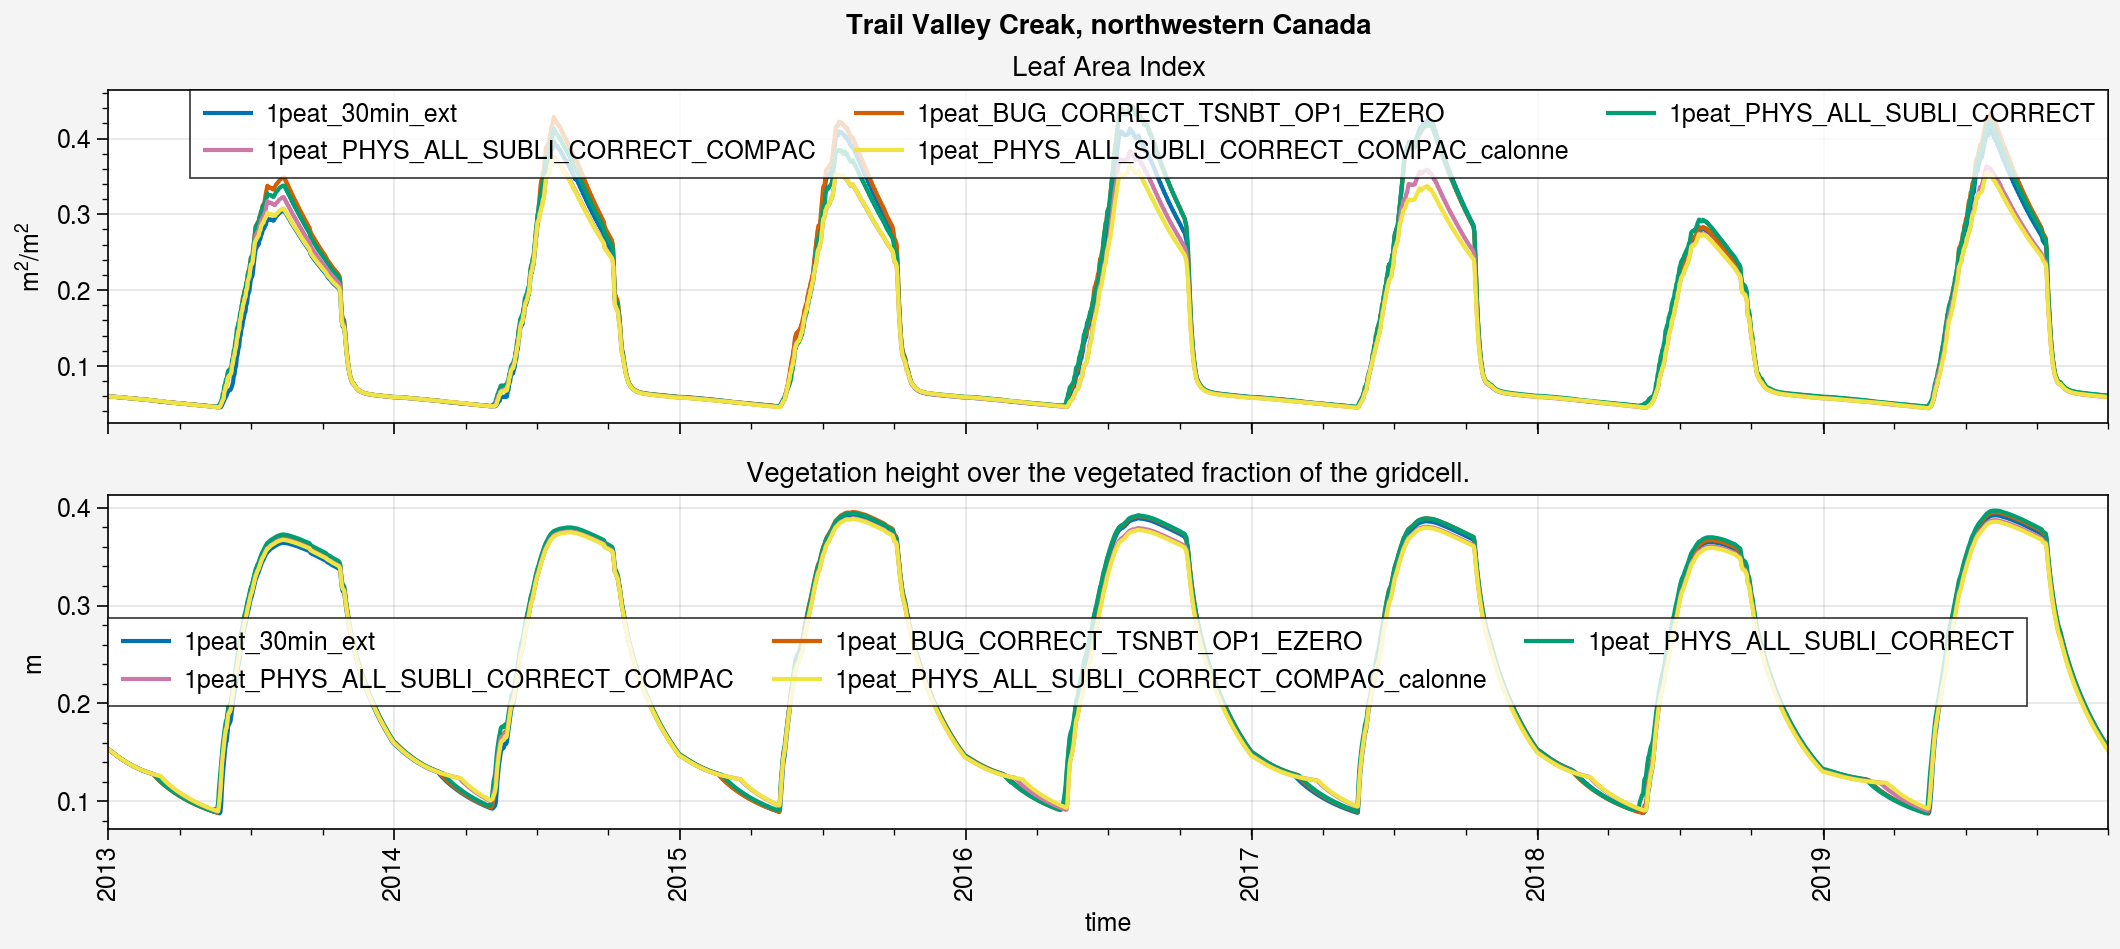

In [126]:
fig, axs = pplt.subplots(ncols=1, nrows=2, refaspect=6, refwidth=10, sharey=0)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.lai, label=label)
    axs[1].plot(ds_d.vegHeight, label=label)

axs[0].format(ylabel=ds_d_list[0].lai.units, title=ds_d_list[0].lai.long_name)
axs[1].format(ylabel=ds_d_list[0].vegHeight.units, title=ds_d_list[0].vegHeight.long_name)

for ax in axs:
    ax.legend()

fig.suptitle(site_longname)

Text(0.5, 0.98, 'Trail Valley Creak, northwestern Canada (2013-2019)')

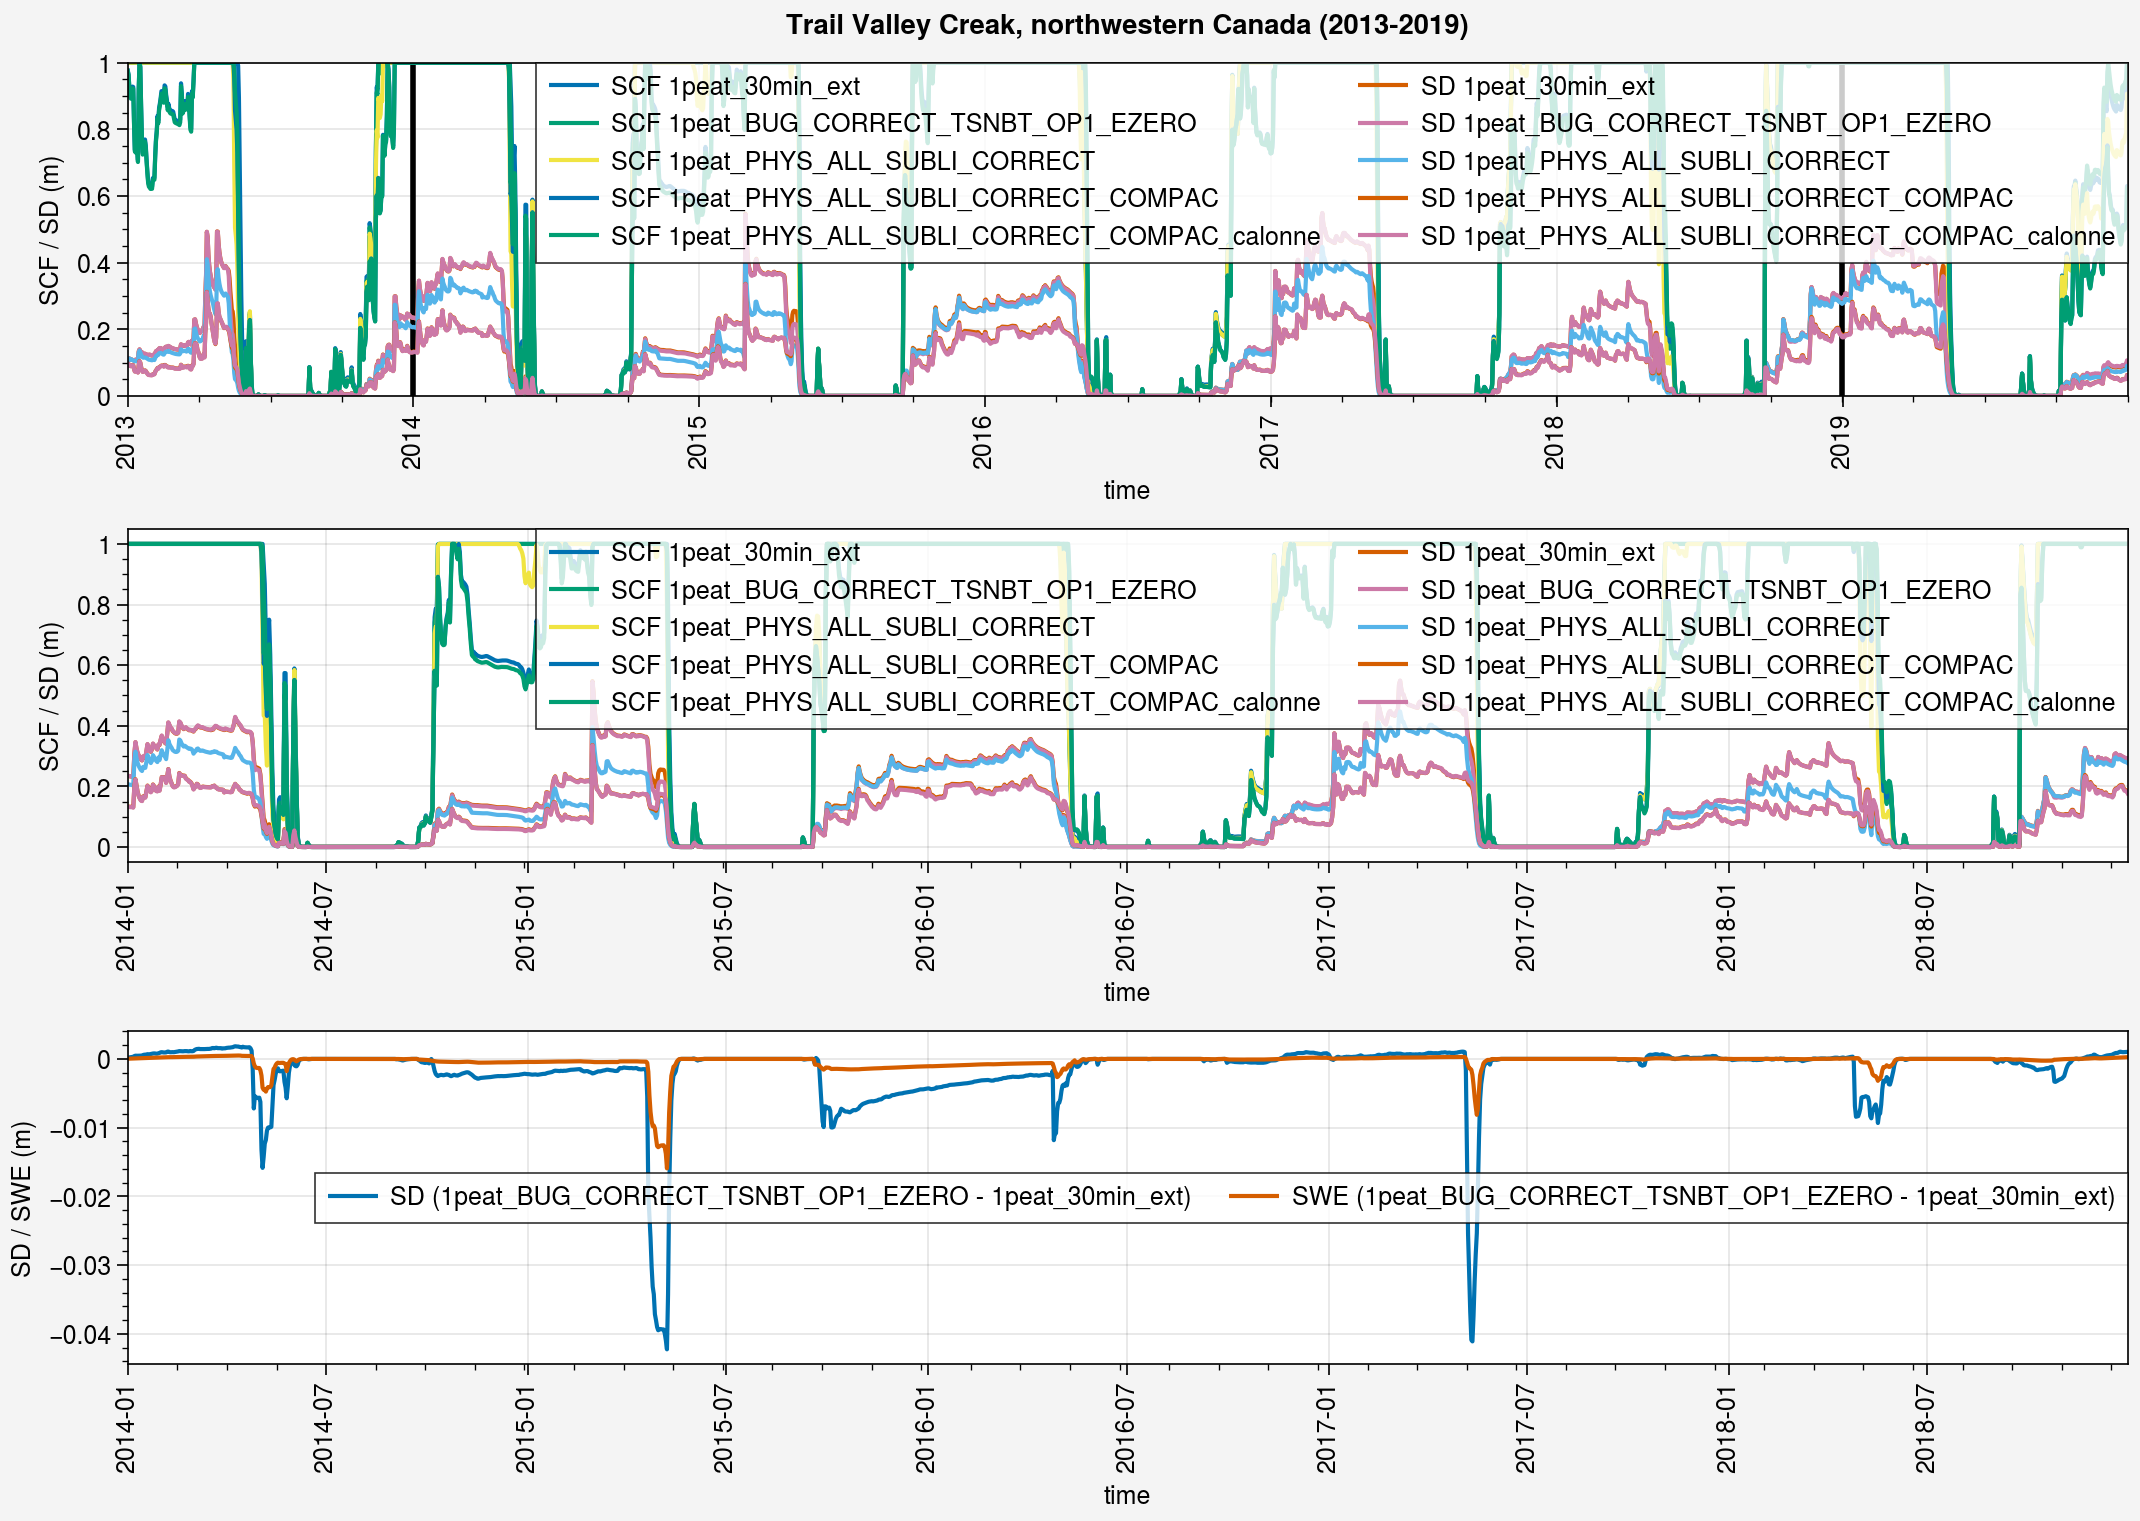

In [127]:
if len(labels) > 1:
    nrows = 3
else: 
    nrows = 2
    
fig, axs = pplt.subplots(ncols=1, nrows=nrows, refaspect=6, refwidth=10, share=0)

##################
### All period ###
##################
start = str(y_start)
end = str(y_end)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[0].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].legend(ncols=2, loc='ur')
axs[0].format(
    ylabel='SCF / SD (m)'
)


############
### Zoom ###
############
start = str(y_start+1)
end = str(y_end-1)

for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[1].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[0], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)
axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[-1], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)

axs[1].legend(ncols=2, loc='ur')
axs[1].format(
    ylabel='SCF / SD (m)'
)

if nrows == 3:
    #####################
    ### SWE / SD diff ###
    #####################
    axs[2].plot((ds_d_list[1]-ds_d_list[0]).snd.sel(time=slice(start,end)), label='SD ('+labels[1]+' - '+labels[0]+')')
    axs[2].plot(((ds_d_list[1]-ds_d_list[0]).snw*1e-3).sel(time=slice(start,end)), label='SWE ('+labels[1]+' - '+labels[0]+')')
    
    axs[2].legend(ncols=2)
    axs[2].format(
        ylabel='SD / SWE (m)'
    )

fig.suptitle(site_longname+' ('+str(y_start)+'-'+str(y_end)+')')


## Compare with obs

In [12]:
path_obs = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/TVC/TVCSnowCLM/TVCMetData'
ds_h_obs = xr.open_dataset(path_obs+'/obs_insitu_tvc_2017_2019.nc')
ds_d_obs = ds_h_obs.resample(time='D').mean().load()
ds_d_obs['snd_auto'] = ds_d_obs.snd_auto/100
ds_d_obs = ds_d_obs.rename({'albedo': 'albs', 'swc': 'mrsll'})
ds_d_obs

<xarray.Dataset> Size: 112kB
Dimensions:           (time: 668, sdepth: 4)
Coordinates:
  * sdepth            (sdepth) float64 32B 0.02 0.05 0.1 0.2
  * time              (time) datetime64[ns] 5kB 2017-09-01 ... 2019-06-30
Data variables: (12/14)
    snd_auto          (time) float64 5kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tsl               (time, sdepth) float64 21kB 5.021 3.834 ... 5.732 4.72
    mrsll             (time, sdepth) float64 21kB 0.232 0.1819 ... 0.287 0.433
    SoilHEatFlux_org  (time) float64 5kB 6.104 11.39 9.86 1.357 ... nan nan nan
    SoilHEatFlux_min  (time) float64 5kB 5.848 12.86 11.75 7.613 ... nan nan nan
    NEE_filt          (time) float64 5kB -0.8253 0.1094 0.406 ... -2.071 -0.0614
    ...                ...
    NEE_filled        (time) float64 5kB 0.152 0.6982 0.6329 ... -1.871 -0.0614
    LE_filled         (time) float64 5kB 22.29 16.89 21.12 ... 32.07 27.5 -1.015
    H_filled          (time) float64 5kB 17.54 12.97 17.06 ... 78.96 -12.94
    CH4_filt          (time) float64 5kB 0.001279 0.001616 0.002003 ... nan nan
    CH4_filled        (time) float64 5kB 0.001136 0.001072 ... 0.0002559
    albs              (time) float64 5kB 0.1721 0.1551 0.209 ... 0.225 0.331
Attributes:
    location:    Trail Valley Creak
    ref:         https://doi.org/10.5194/tc-16-4201-2022
    soil_ref:    https://doi.pangaea.de/10.1594/PANGAEA.962726
    downloaded:  13/10/2024 by Mickaël Lalande
    merge:       TVCSnowCLM/TVCMetData/MSC_Snowdepth.csv and TVC_CLASSIC_2013...

In [13]:
y_start

2013

In [14]:
y_end

2019

In [15]:
y_start_obs = 2017

In [16]:
tot_year = y_end - y_start_obs + 1
gap = 3
years = pplt.arange(y_start_obs, y_end)
years

array([2017, 2018, 2019])

### SD

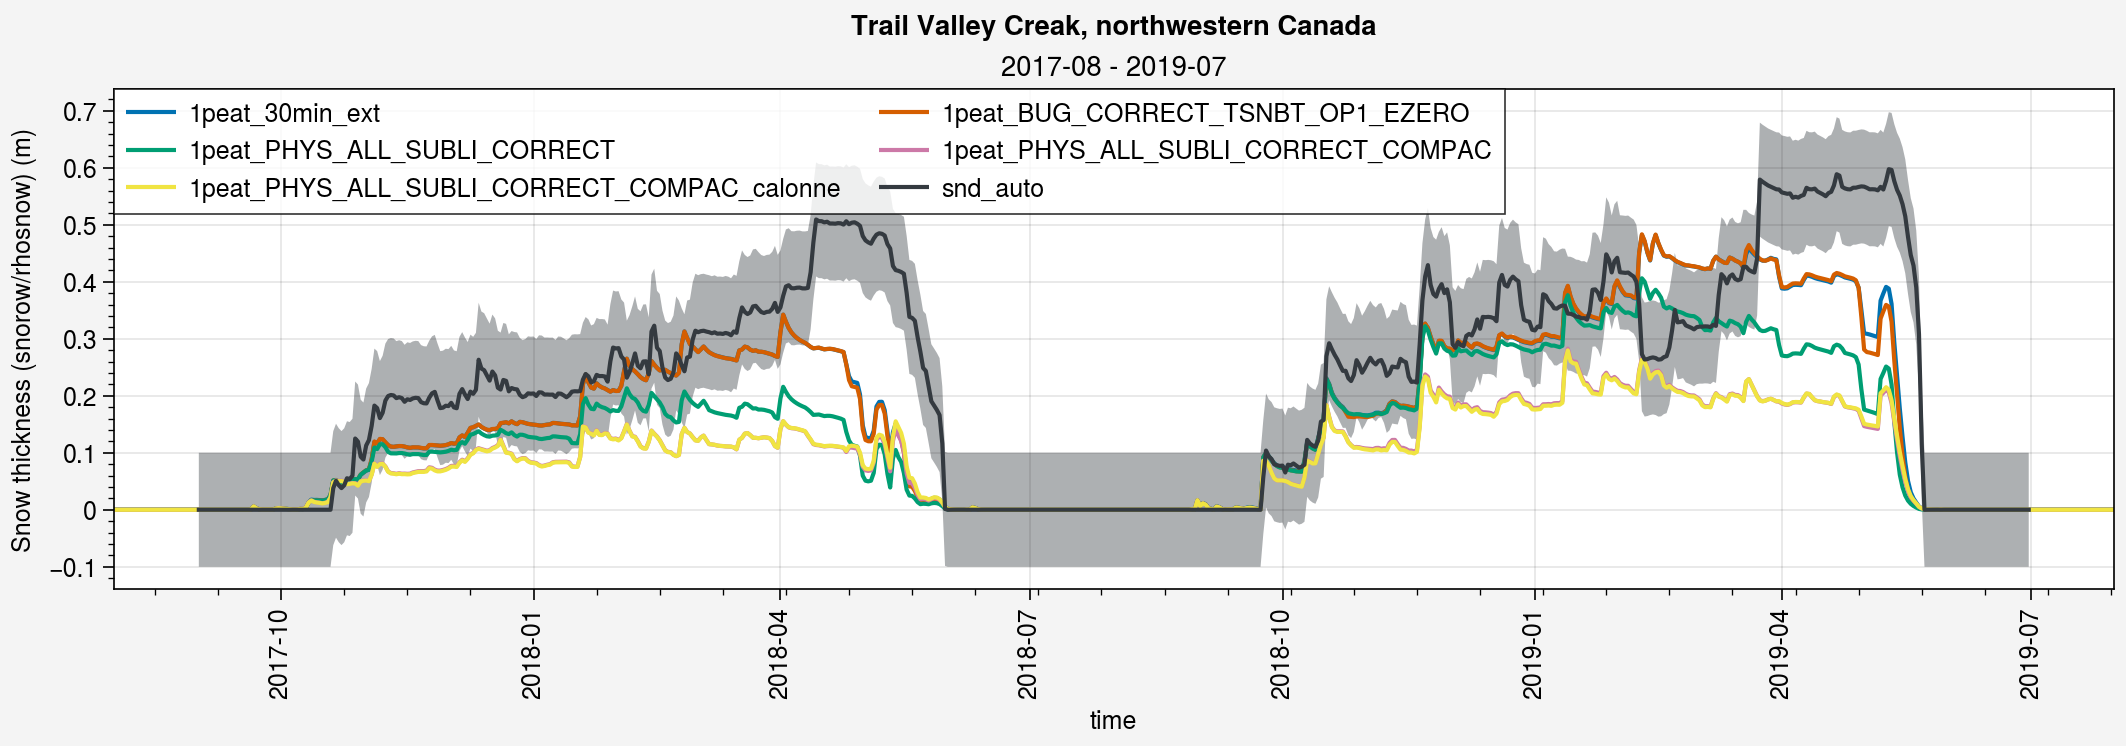

In [128]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snd.sel(time=period), label=label)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)

    # Veg
    # axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop)
    
    fig.suptitle(site_longname)
    # fig.save('bylot_snd.pdf')

### SWE

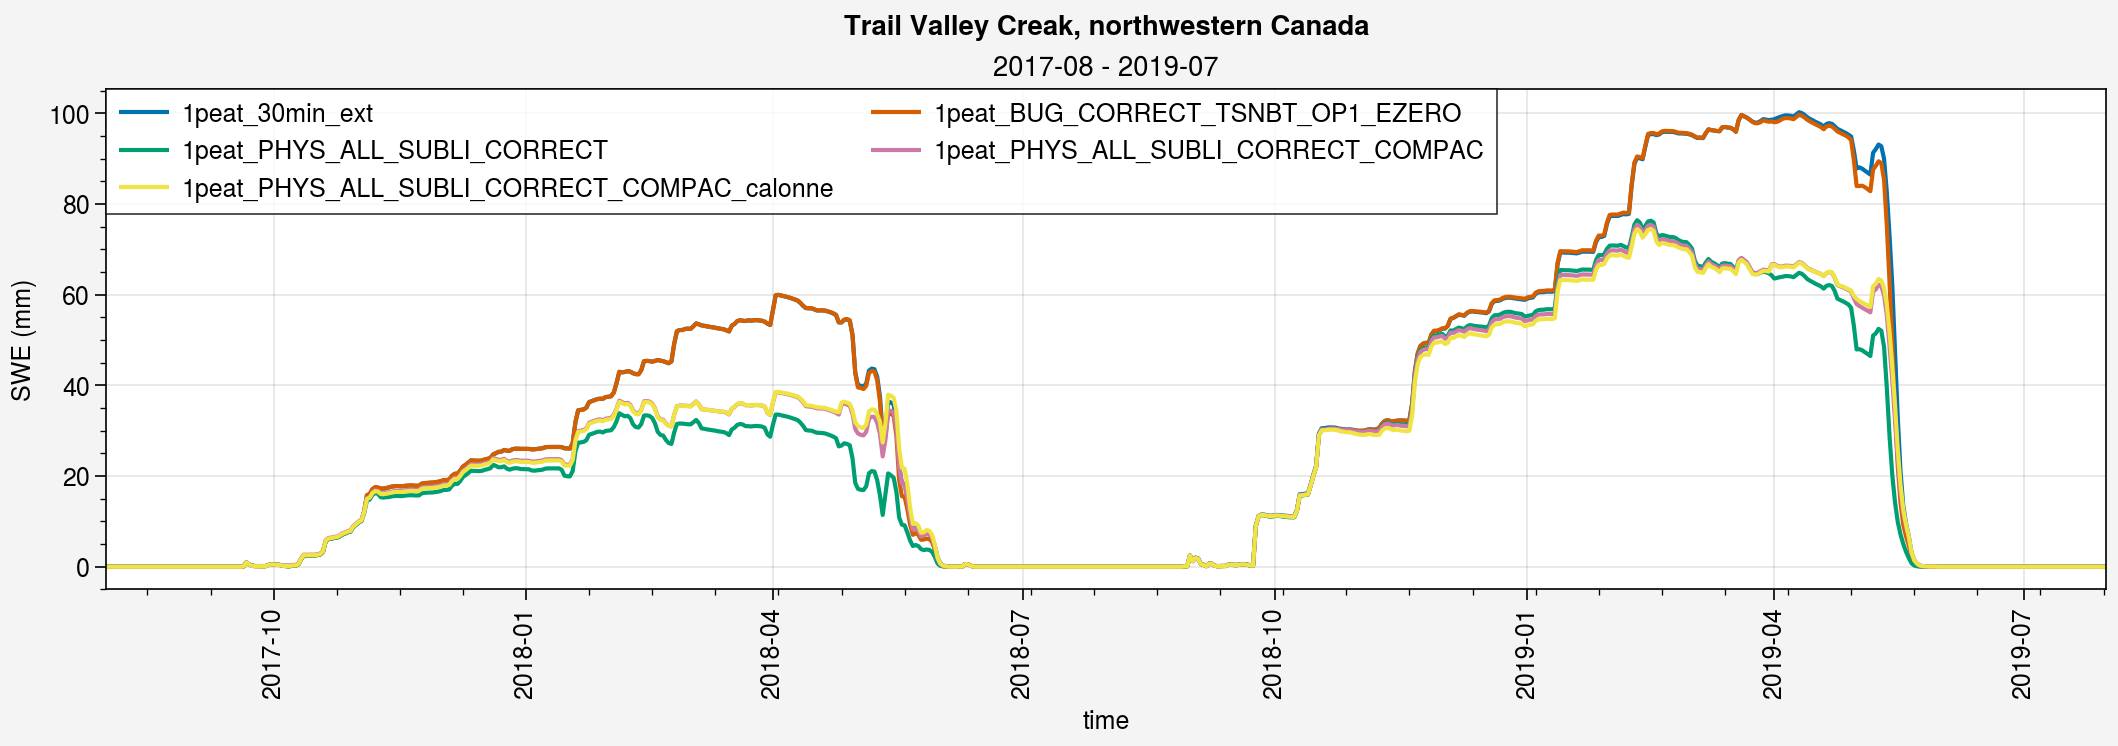

In [129]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snw.sel(time=period), label=label)
    
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values+25, axis=0),
    #     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
    # axs[0].plot(ds_d_obs.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snw_man.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='SWE (mm)')
    
    fig.suptitle(site_longname)


### Albedo

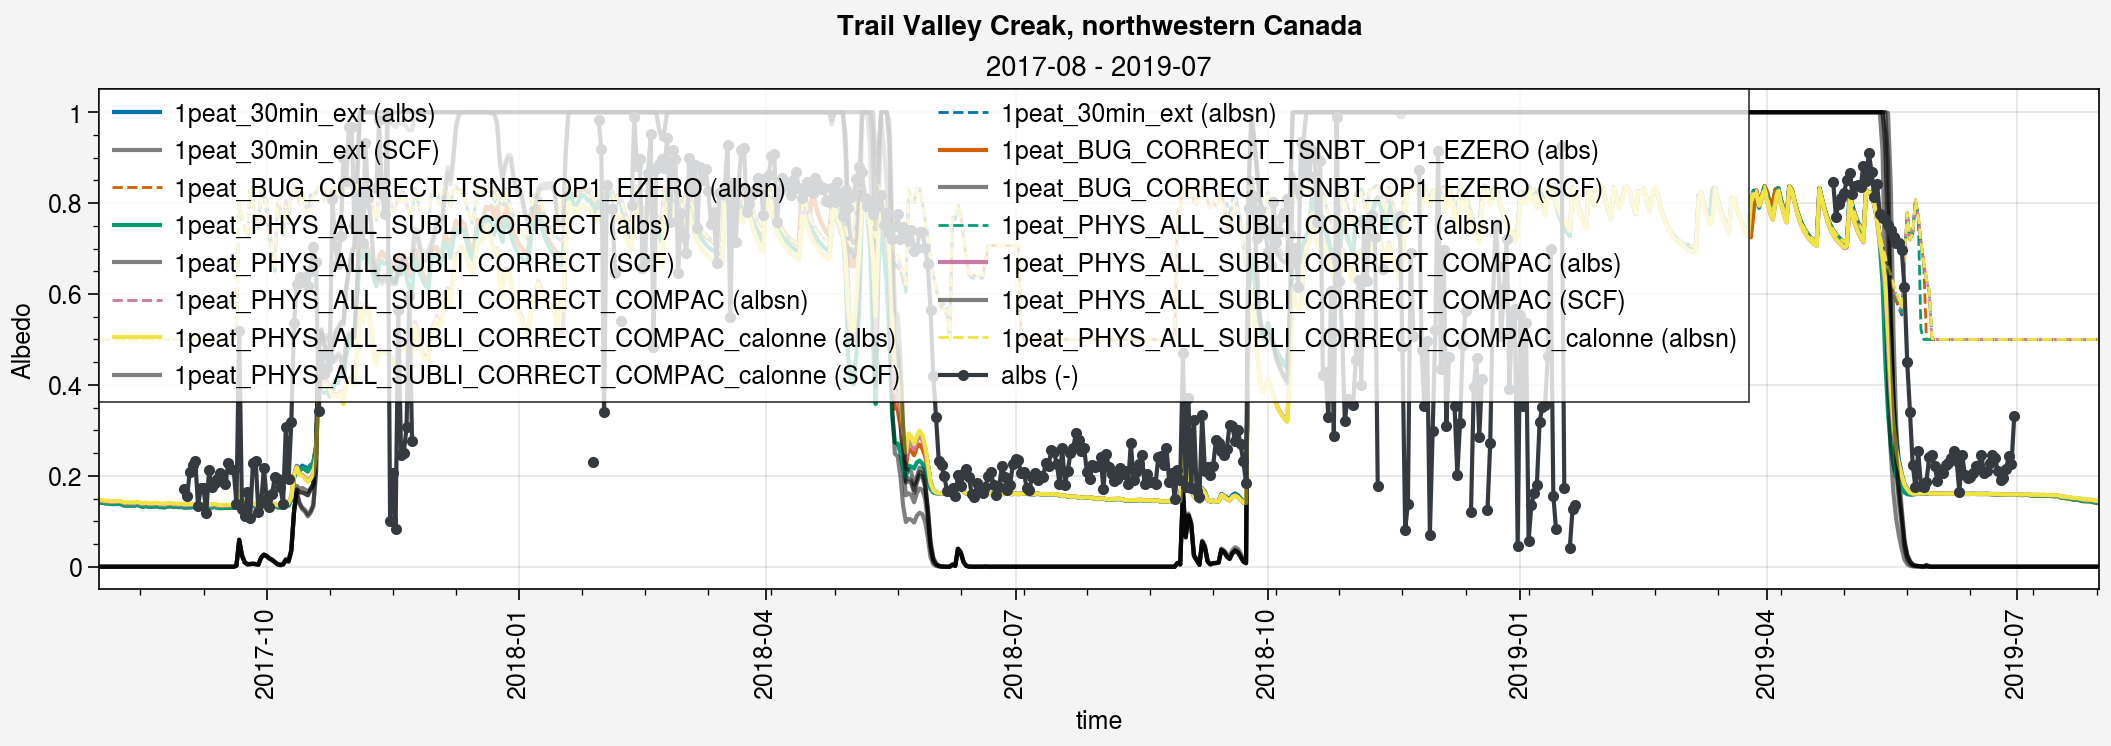

In [130]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    k = 0
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(k))
        axs[0].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(k), ls='--', lw=1)
        axs[0].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)
        
        k+=1
    
    # Obs
    axs[0].plot(ds_d_obs.albs.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Albedo')
    
    fig.suptitle(site_longname)


### Surface Temperature

Domine et al. ([2019](https://onlinelibrary.wiley.com/doi/abs/10.1029/2018MS001445)): "**Averaged over a period of several days the surface temperatures are essentially the same**. The amplitude variations are greater in the Alpine snowpack (Figure 8b) because the insulating layer at the top does not allow damping the air temperature variations by heat exchanges with the snowpack. This effect is more important in April and May, when daily temperature variations reach 20 °C, sometimes more. The absolute temperature differences reaches 4.7 °C on 8 February, when the temperature suddenly increases by 15 °C in 5 hr, and the surface temperature of the Alpine snowpack increases more rapidly."

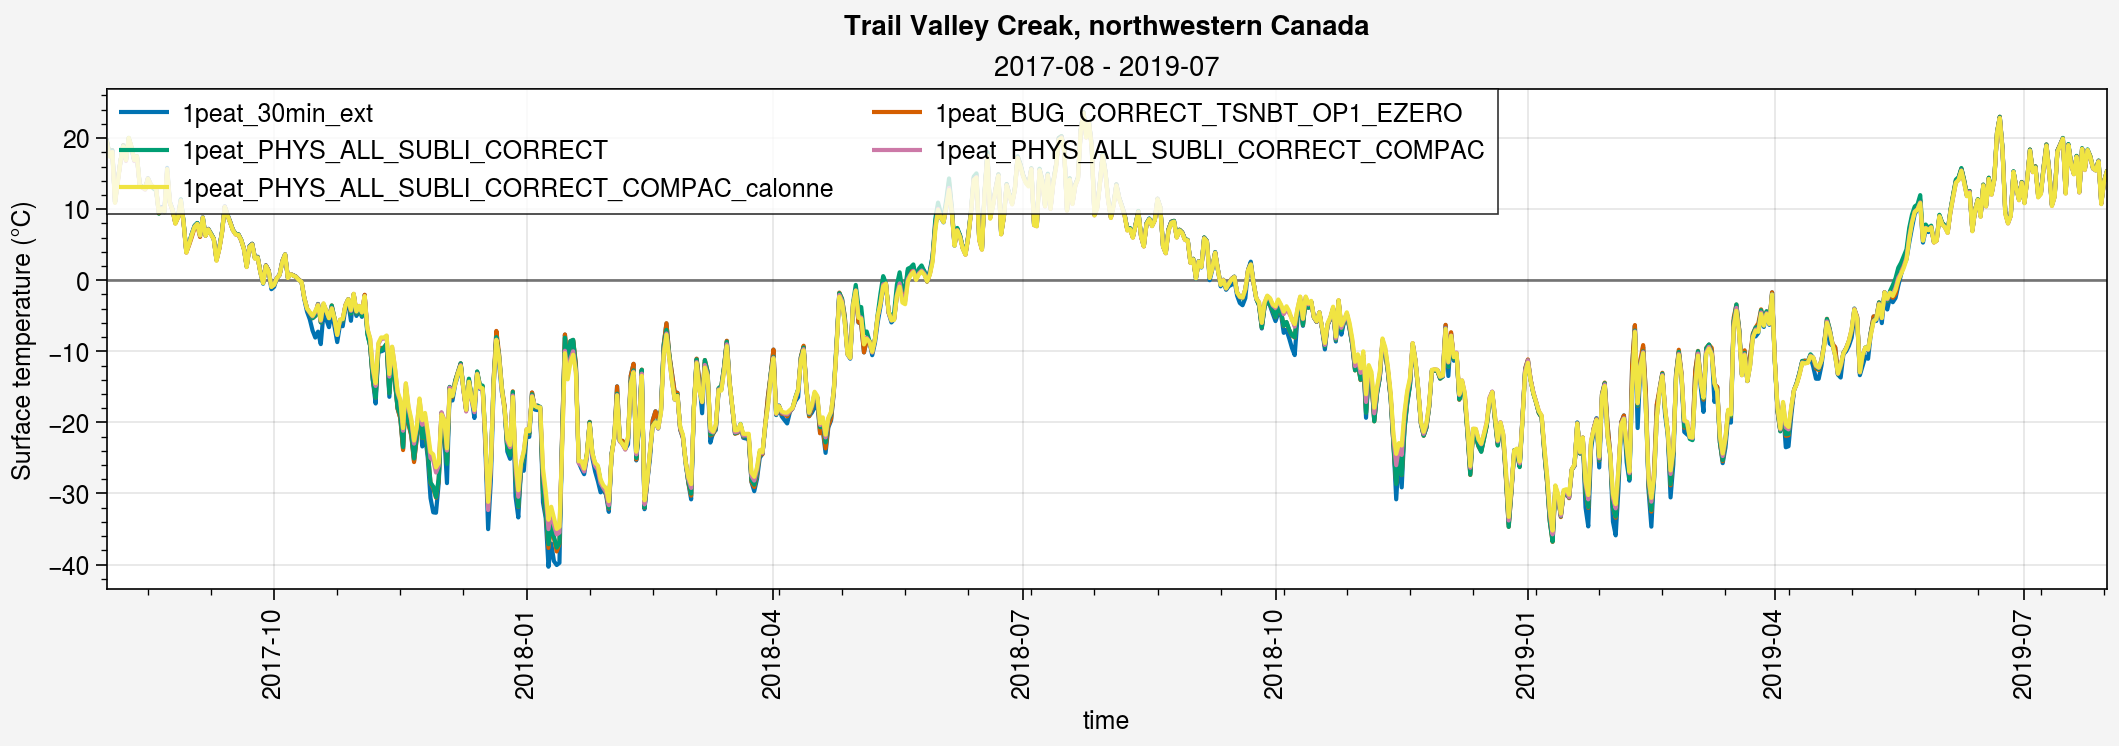

In [131]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.ts.sel(time=period)-273.15, label=label)
    
    # Obs
    # axs[0].plot(ds_d_obs.ts.sel(time=period), color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)


### Soil Temperature

In [132]:
ds_d_obs

<xarray.Dataset> Size: 112kB
Dimensions:           (time: 668, sdepth: 4)
Coordinates:
  * sdepth            (sdepth) float64 32B 0.02 0.05 0.1 0.2
  * time              (time) datetime64[ns] 5kB 2017-09-01 ... 2019-06-30
Data variables: (12/14)
    snd_auto          (time) float64 5kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tsl               (time, sdepth) float64 21kB 5.021 3.834 ... 5.732 4.72
    mrsll             (time, sdepth) float64 21kB 0.232 0.1819 ... 0.287 0.433
    SoilHEatFlux_org  (time) float64 5kB 6.104 11.39 9.86 1.357 ... nan nan nan
    SoilHEatFlux_min  (time) float64 5kB 5.848 12.86 11.75 7.613 ... nan nan nan
    NEE_filt          (time) float64 5kB -0.8253 0.1094 0.406 ... -2.071 -0.0614
    ...                ...
    NEE_filled        (time) float64 5kB 0.152 0.6982 0.6329 ... -1.871 -0.0614
    LE_filled         (time) float64 5kB 22.29 16.89 21.12 ... 32.07 27.5 -1.015
    H_filled          (time) float64 5kB 17.54 12.97 17.06 ... 78.96 -12.94
    CH4_filt          (time) float64 5kB 0.001279 0.001616 0.002003 ... nan nan
    CH4_filled        (time) float64 5kB 0.001136 0.001072 ... 0.0002559
    albs              (time) float64 5kB 0.1721 0.1551 0.209 ... 0.225 0.331
Attributes:
    location:    Trail Valley Creak
    ref:         https://doi.org/10.5194/tc-16-4201-2022
    soil_ref:    https://doi.pangaea.de/10.1594/PANGAEA.962726
    downloaded:  13/10/2024 by Mickaël Lalande
    merge:       TVCSnowCLM/TVCMetData/MSC_Snowdepth.csv and TVC_CLASSIC_2013...

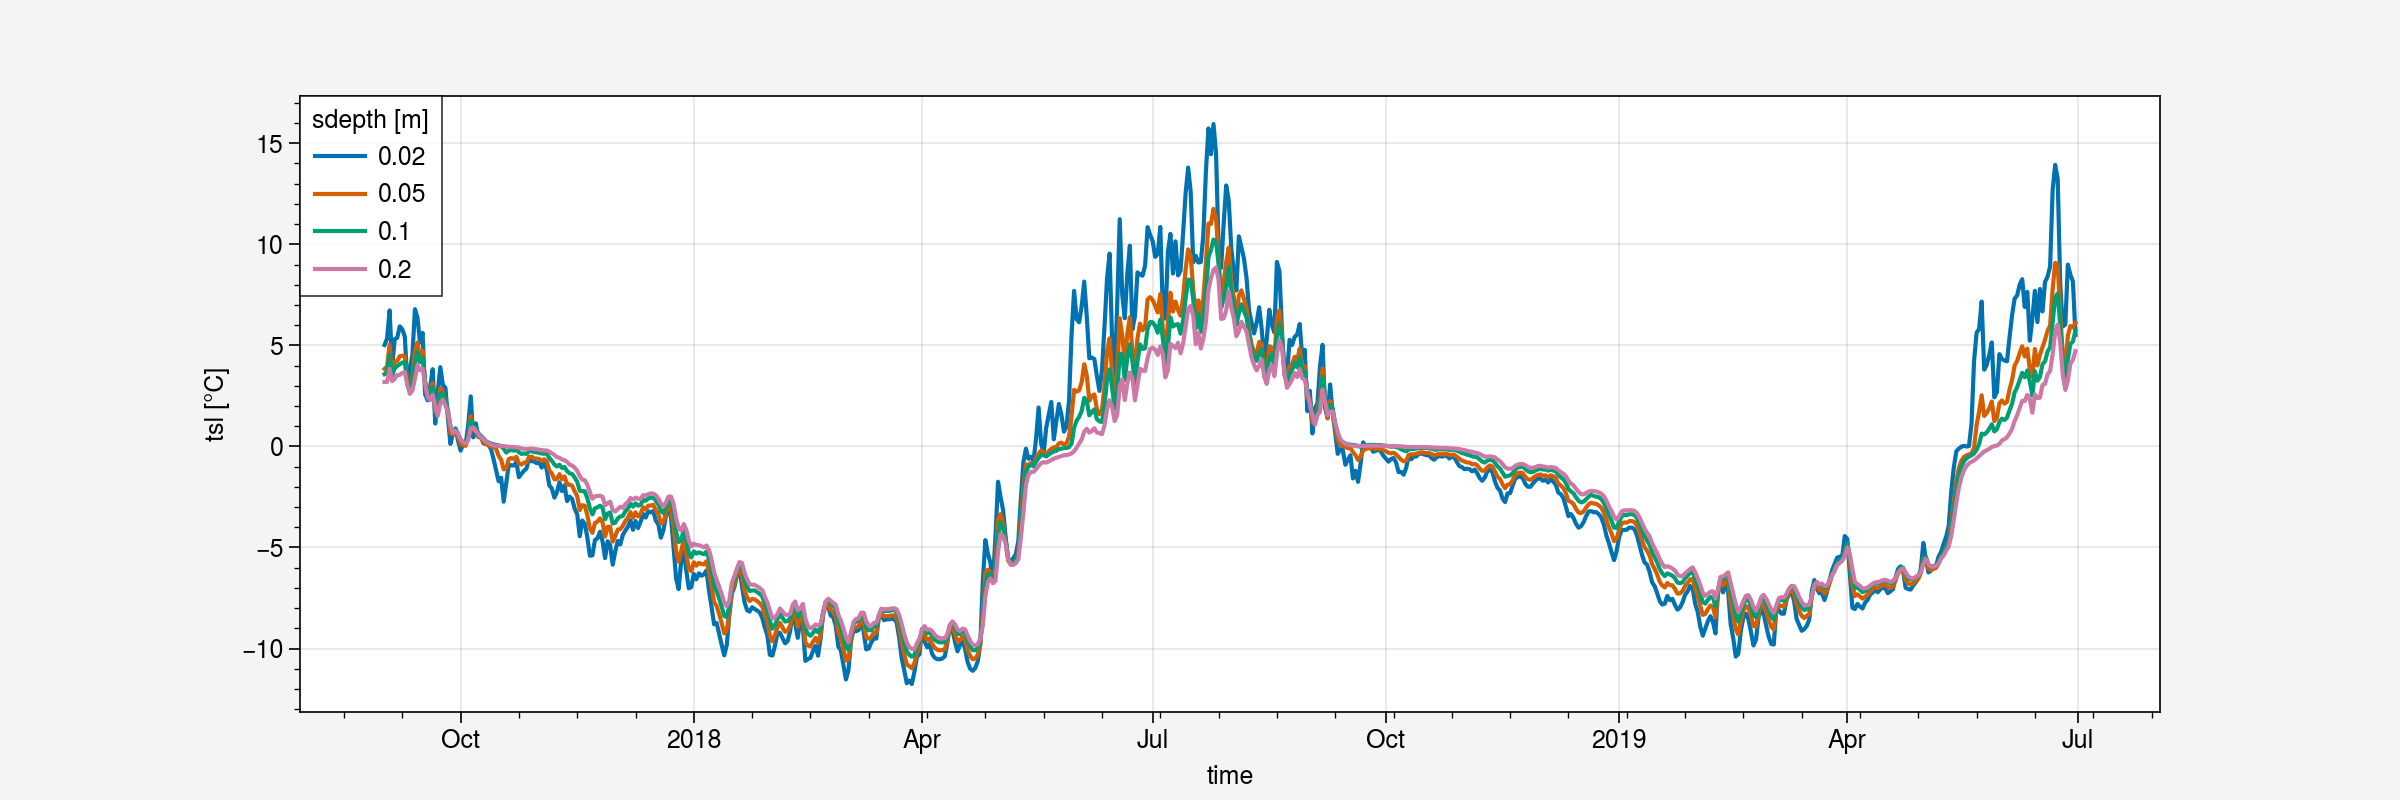

In [133]:
%matplotlib inline
ds_d_obs.tsl.plot(hue='sdepth', figsize=(12, 4))

In [134]:
ds_d_list[0]

<xarray.Dataset> Size: 3MB
Dimensions:     (time: 2555, layer: 20)
Coordinates:
  * time        (time) datetime64[ns] 20kB 2013-01-01 2013-01-02 ... 2019-12-31
  * layer       (layer) float64 160B 0.05 0.15 0.25 0.35 ... 8.9 18.9 41.4 58.9
Data variables: (12/54)
    longitude   float64 8B -133.5
    latitude    float64 8B 68.75
    actlyr      (time) float64 20kB 0.2817 0.2705 0.2608 ... 0.3174 0.2973
    albs        (time) float64 20kB 0.7255 0.7463 0.7492 ... 0.651 0.7204 0.6951
    albsir      (time) float64 20kB 0.6276 0.6478 0.6493 ... 0.6215 0.5915
    albsn       (time) float64 20kB 0.8303 0.8383 0.8338 ... 0.8242 0.7986
    ...          ...
    tsn         (time) float64 20kB 257.5 260.4 261.7 ... 251.4 254.5 254.6
    tsnbot      (time) float64 20kB nan nan nan nan nan ... nan nan nan nan nan
    vegHeight   (time) float64 20kB 0.1531 0.1525 0.1519 ... 0.1562 0.155 0.1539
    wsnw        (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wtd         (time) float64 20kB 9.999e+03 9.999e+03 ... 9.999e+03 9.999e+03
    zpond       (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:        CLASSIC output file
    timestamp:    20241121 1510
    Conventions:  COARDS
    node_offset:  1
    Comment:       run Ref

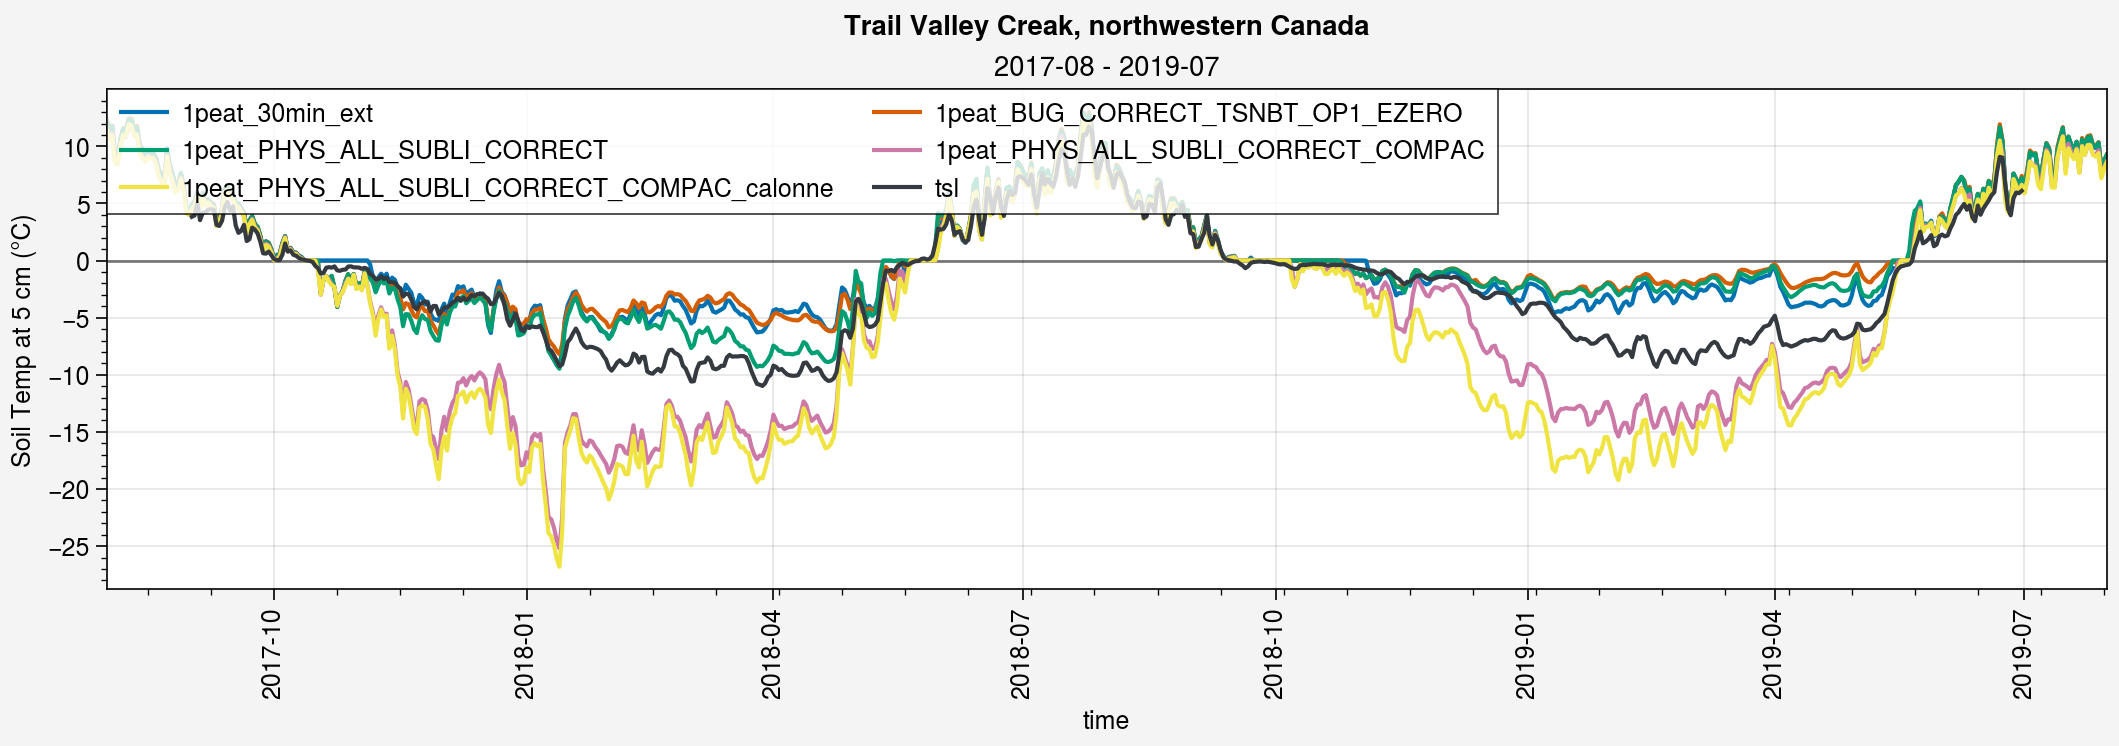

In [135]:
%matplotlib inline
gap = 3
color_obs = 'gray8'
sdepth = 0.05
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=sdepth)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth, method='nearest')-273.15, label=label)
        
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    # axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    axs[0].plot(ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


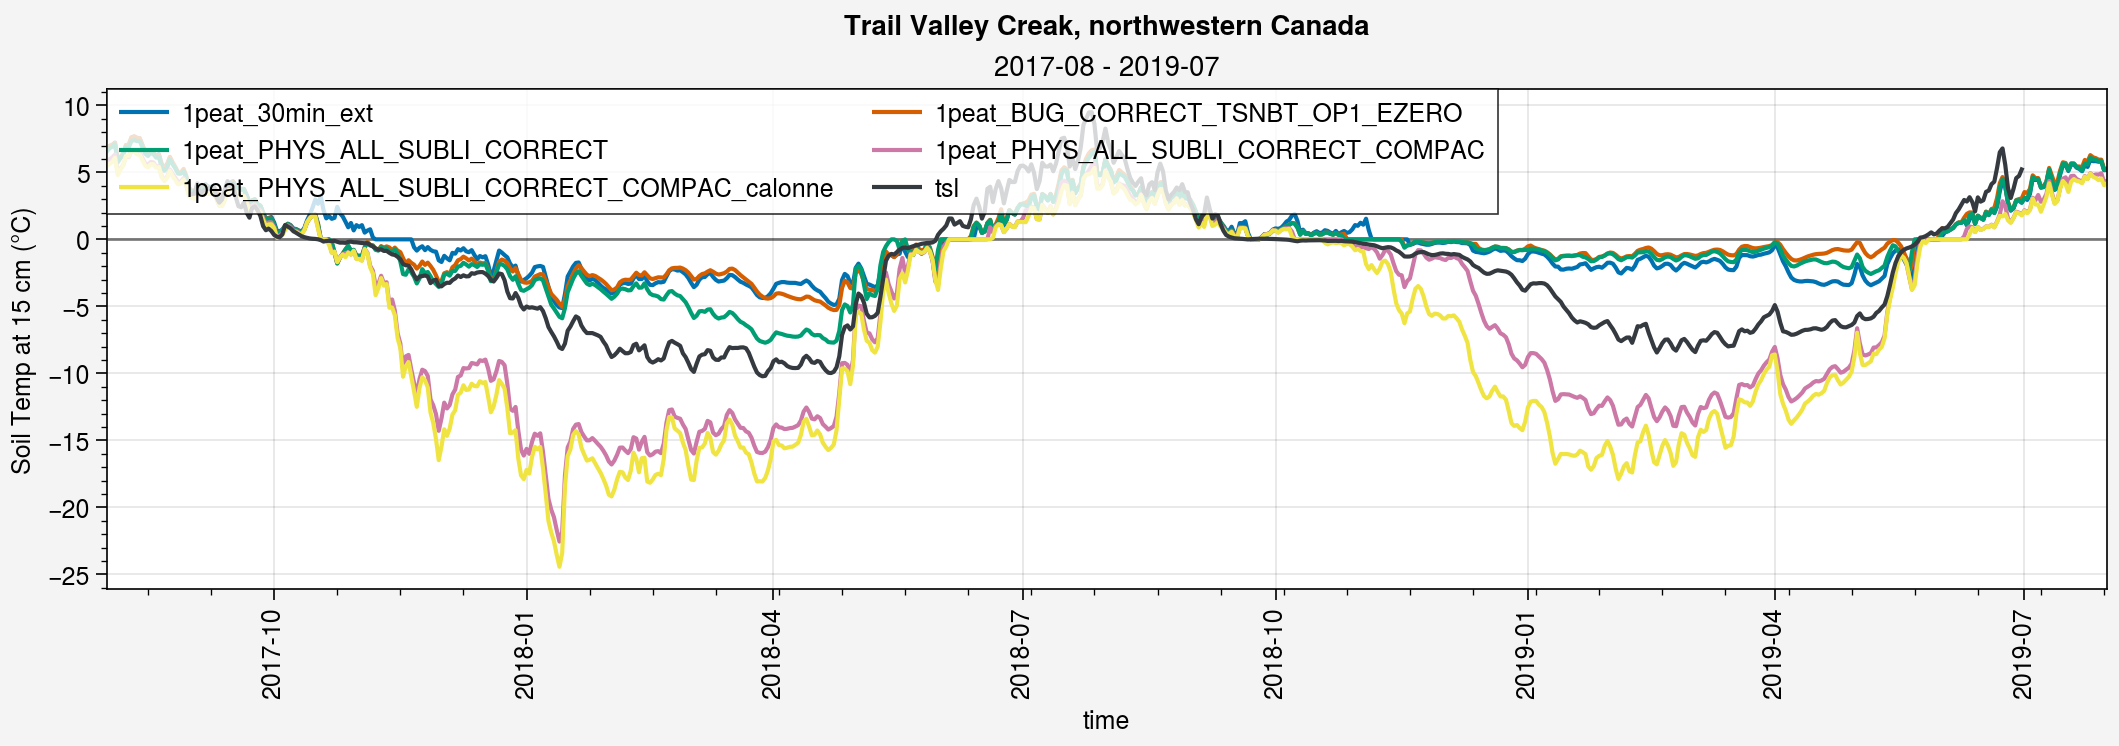

In [136]:
%matplotlib inline
gap = 3
color_obs = 'gray8'
sdepth = 0.15
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=sdepth)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).sel(layer=sdepth, method='nearest')-273.15, label=label)
        
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
    #     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
    # axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
    axs[0].plot(ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at '+sdepth_label+' cm (°C)')
    
    fig.suptitle(site_longname)


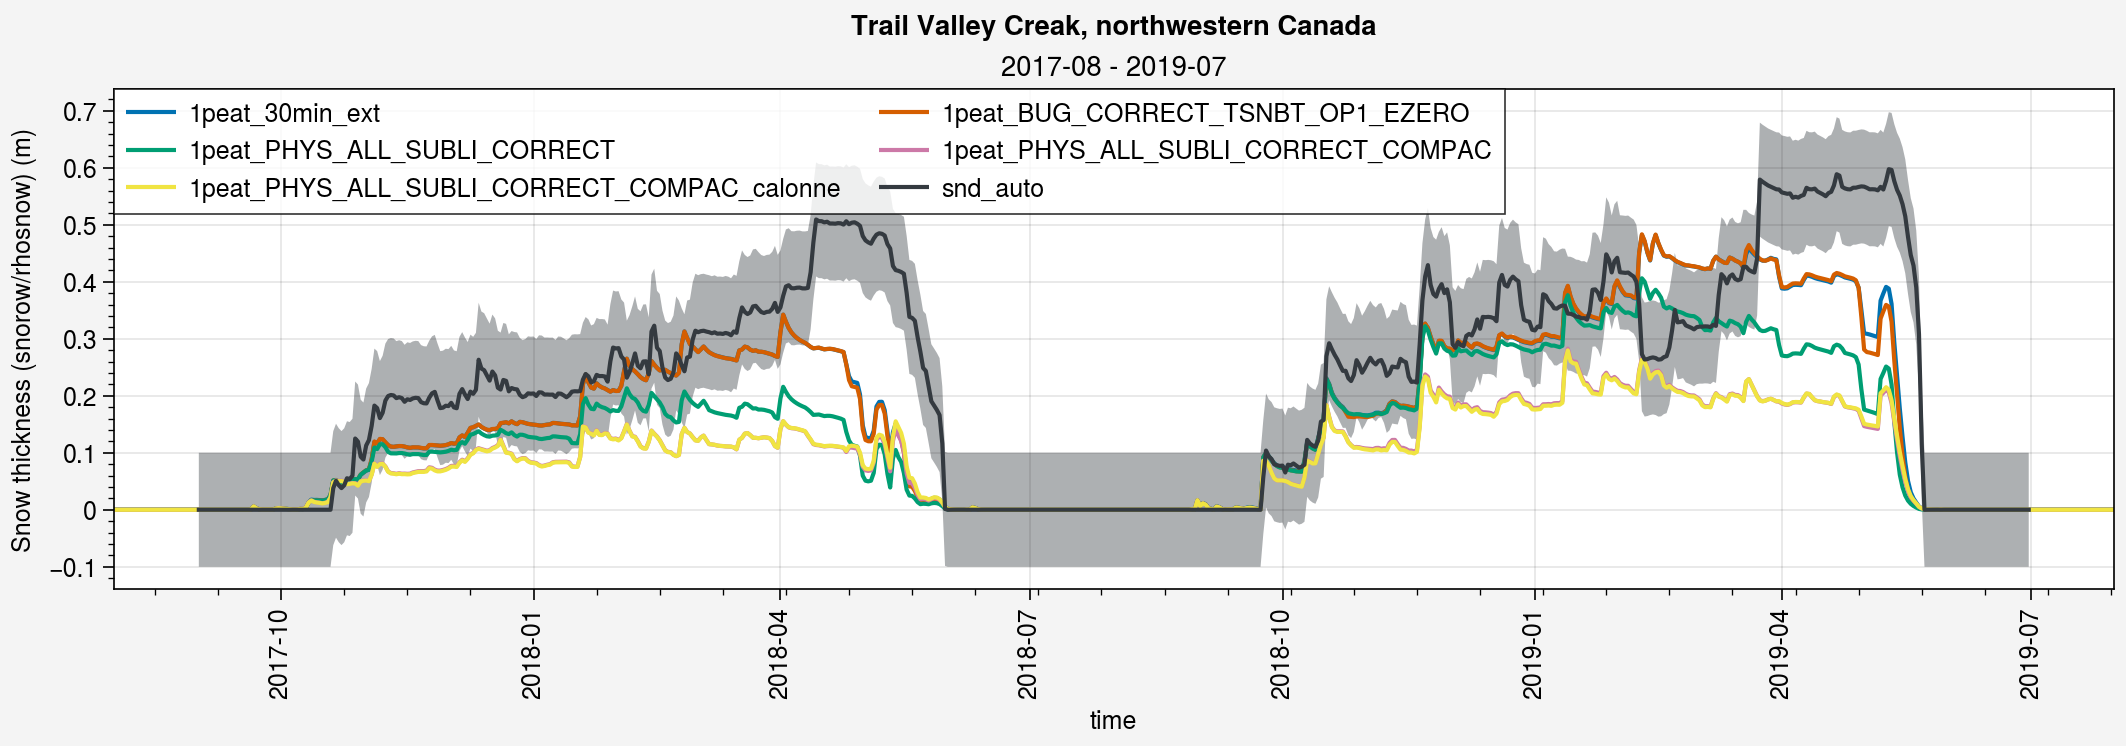

In [137]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snd.sel(time=period), label=label)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values+0.1, axis=0),
        np.expand_dims(ds_d_obs.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    axs[0].plot(ds_d_obs.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    # axs[0].plot(ds_d_obs.snd_man.sel(time=period), marker='.', color=color_obs)

    # Veg
    # axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop)
    
    fig.suptitle(site_longname)
    # fig.save('bylot_snd.pdf')

### Volumetric water content

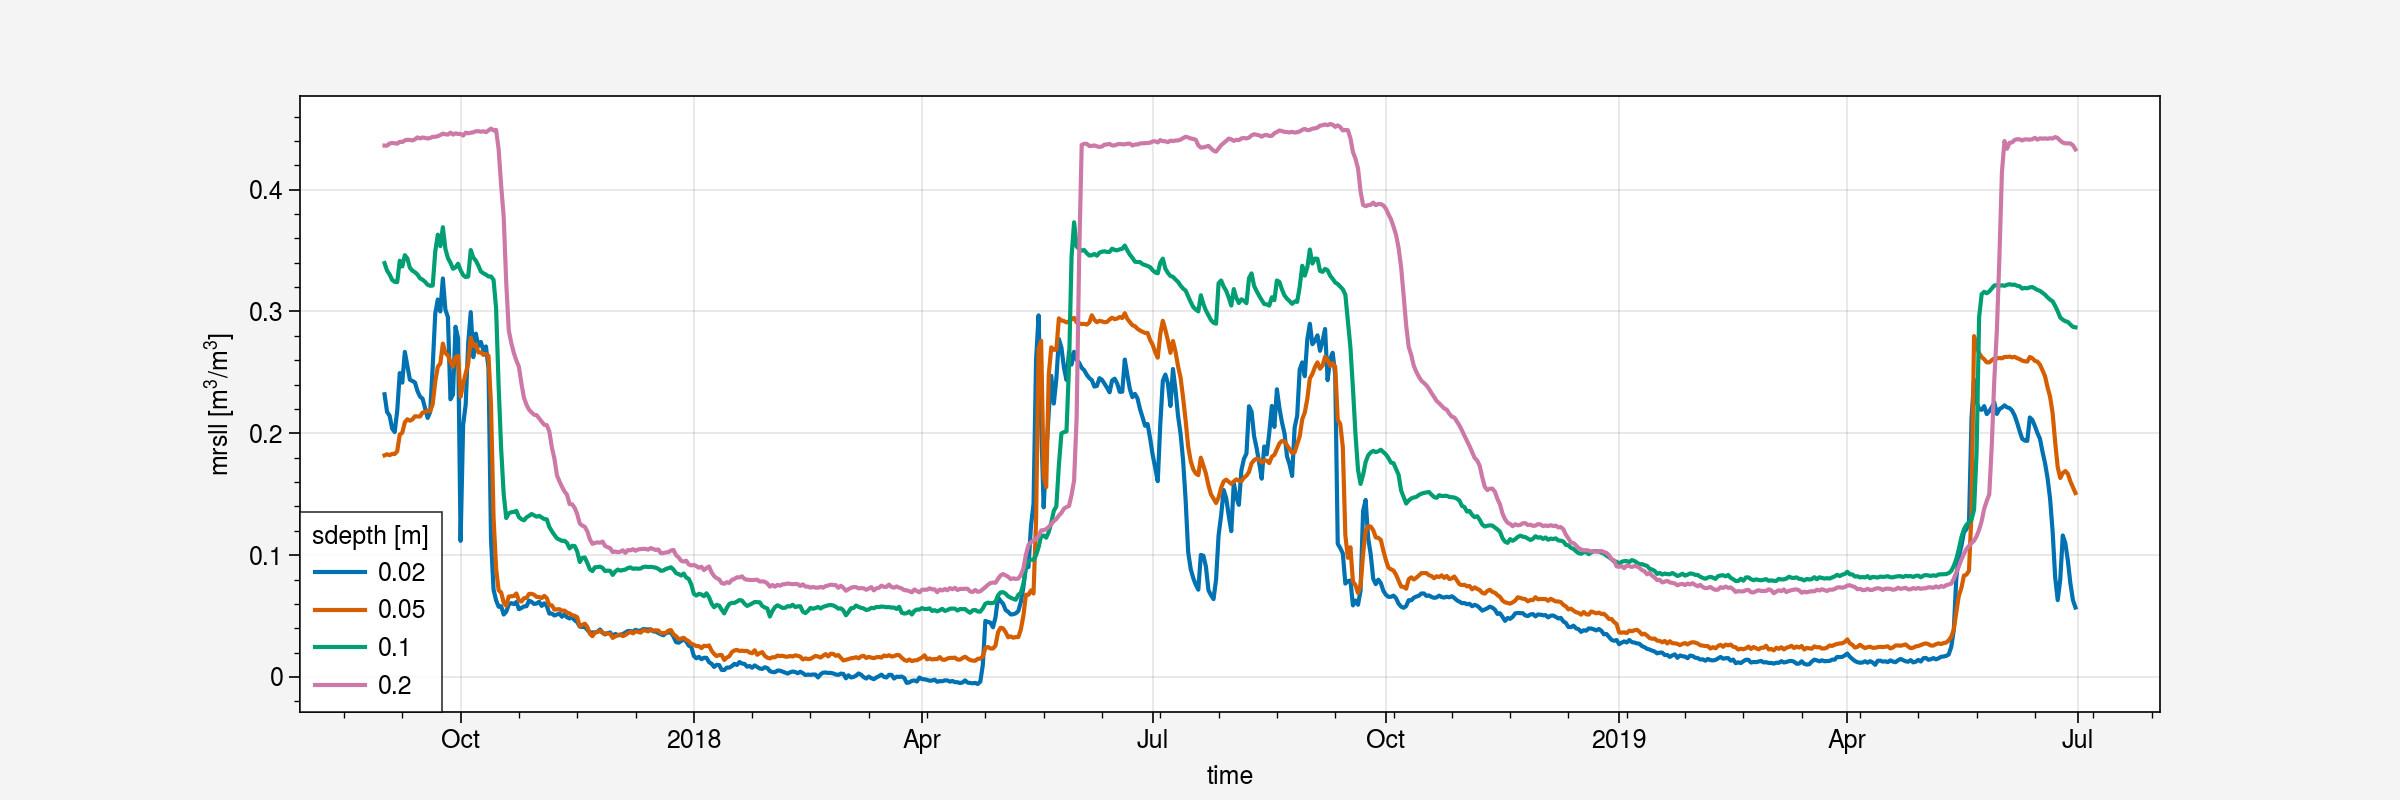

In [138]:
%matplotlib inline
ds_d_obs.mrsll.plot(hue='sdepth', figsize=(12, 4))

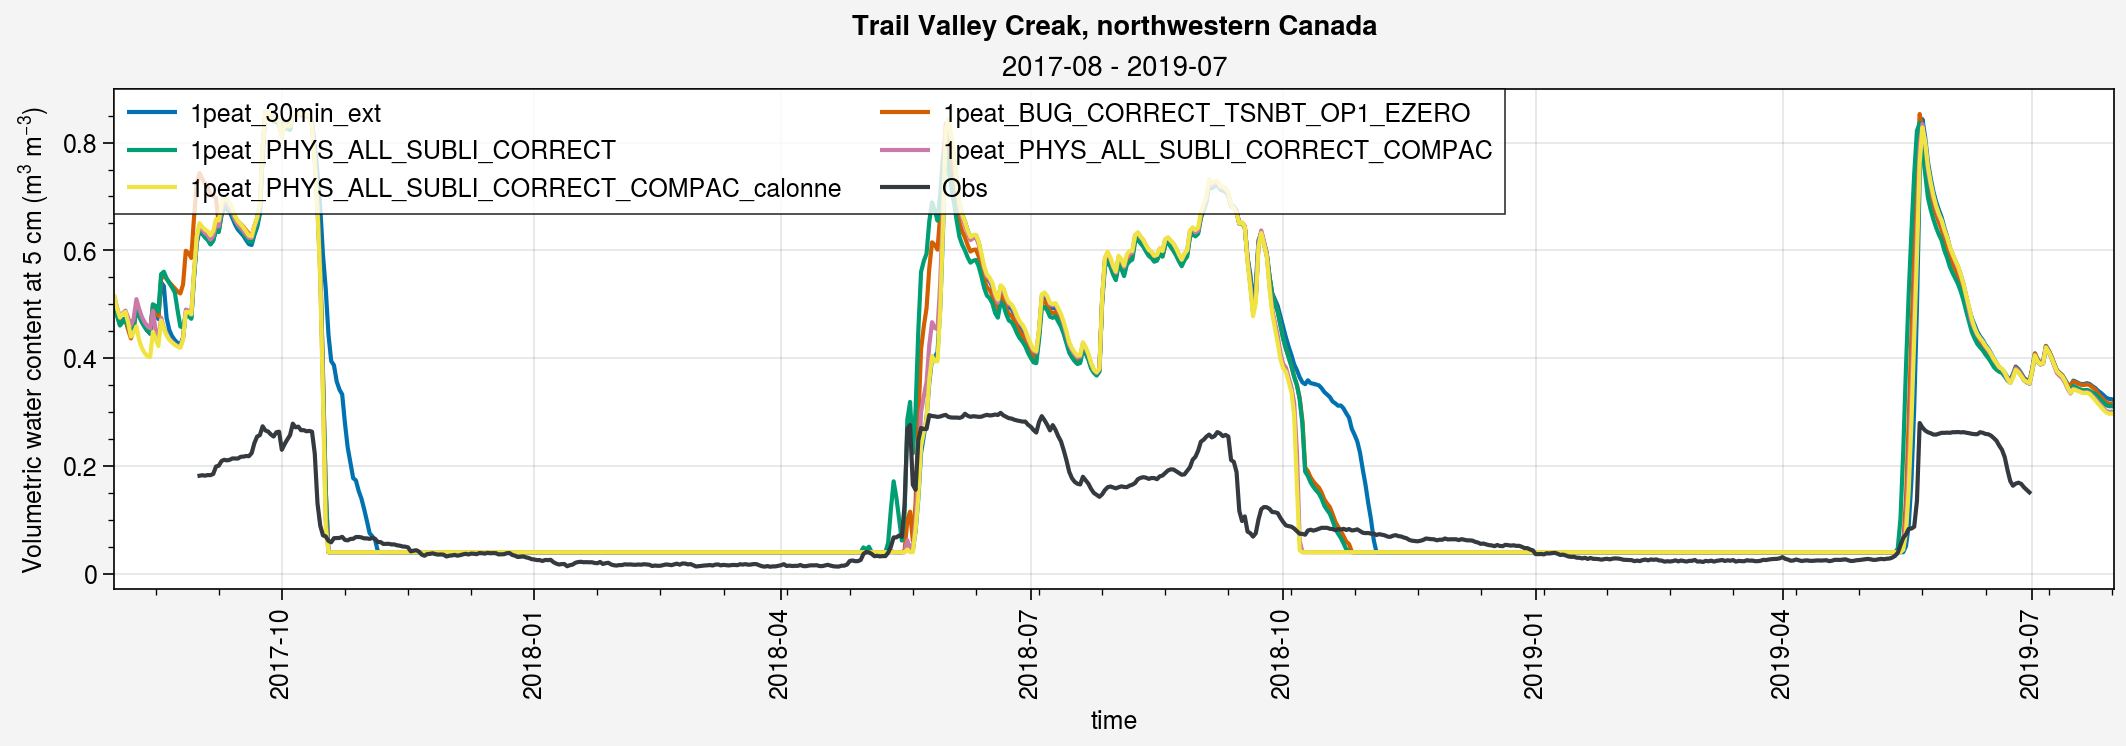

In [139]:
%matplotlib inline
gap = 3
color_obs = 'gray8'
sdepth = 0.05
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth, method='nearest')/100, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.mrsll.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Volumetric water content at '+sdepth_label+' cm (m$^3$ m$^{-3}$)')
    
    fig.suptitle(site_longname)


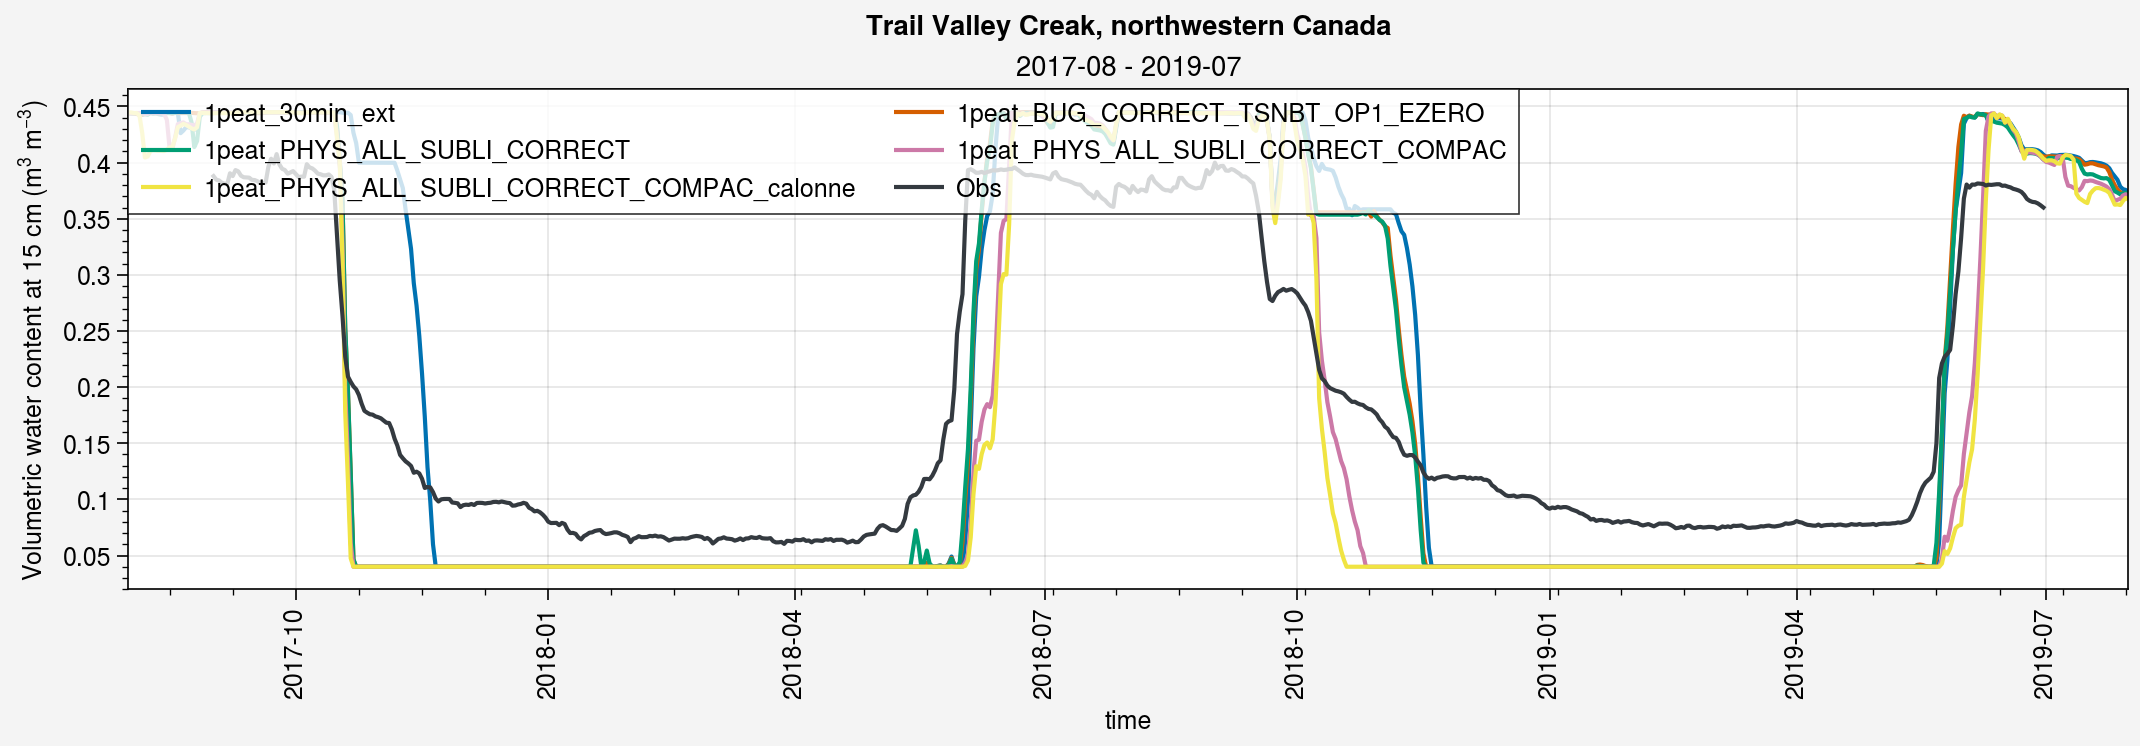

In [140]:
%matplotlib inline
gap = 3
color_obs = 'gray8'
sdepth = 0.15
sdepth_label = str(int(sdepth*100))

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth, method='nearest')/100, label=label)
        
    # Obs
    axs[0].plot(ds_d_obs.mrsll.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs, label='Obs')
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Volumetric water content at '+sdepth_label+' cm (m$^3$ m$^{-3}$)')
    
    fig.suptitle(site_longname)


## All

Text(0.5, 0.98, 'Trail Valley Creak, northwestern Canada')

/home/lalandmi/miniconda3/envs/sc2_v0/lib/python3.10/site-packages/proplot/axes/base.py:1302: RuntimeWarning: divide by zero encountered in scalar divide
  x_pad = self._title_pad / (72 * width)


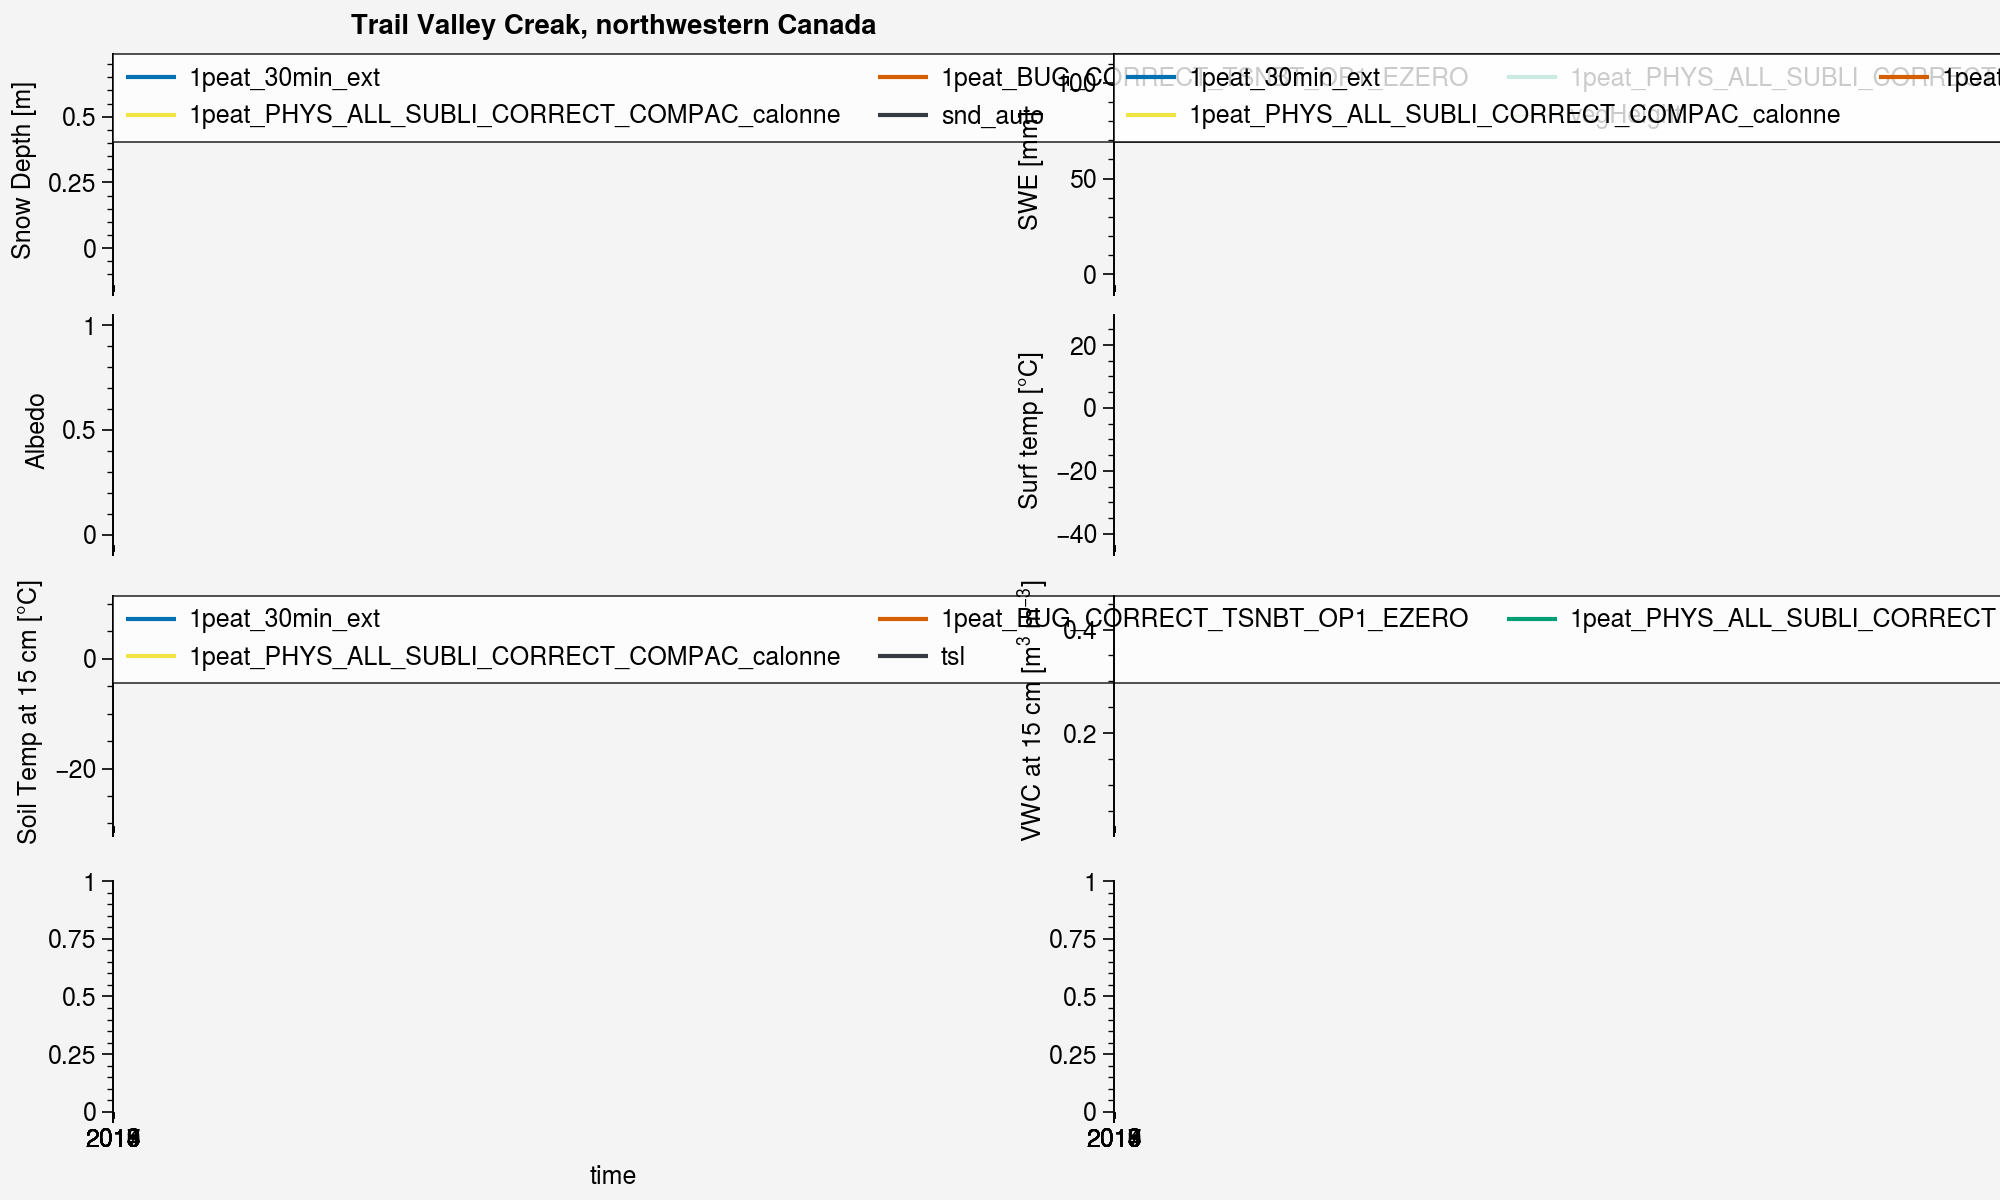

In [141]:
%matplotlib inline
fig, axs = pplt.subplots(nrows=4, ncols=2, figsize=(10,6), sharey=0)

lw = 0.5
period = slice(None, None)

##################
### Snow Depth ###
##################
ax = axs[0]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.sel(time=period).snd, label=label)

# Obs
shadedata = np.concatenate((
    np.expand_dims(ds_d_obs.sel(time=period).snd_auto.values+0.1, axis=0),
    np.expand_dims(ds_d_obs.sel(time=period).snd_auto.values-0.1, axis=0),), axis=0)
ax.plot(ds_d_obs.sel(time=period).snd_auto, shadedata=shadedata, color=color_obs)

# Veg
ax.plot(ds_d_list[0].sel(time=period).vegHeight, label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)

ax.legend(loc='ul', ncols=4)
ax.format(ylabel='Snow Depth [m]')


##################
### SWE ###
##################
ax = axs[1]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.snw.sel(time=period), label=label)

# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values+25, axis=0),
#     np.expand_dims(ds_d_obs.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
# axs[0].plot(ds_d_obs.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
# axs[0].plot(ds_d_obs.snw_man.sel(time=period), marker='.', color=color_obs)

ax.legend(loc='ul', ncols=4)
ax.format(ylabel='SWE [mm]')


##################
### Albedo ###
##################

# Simus
k = 0
ax = axs[2]
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(k))
    ax.plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(k), ls='--', lw=1)
    ax.plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)
    
    k+=1

# Obs
ax.plot(ds_d_obs.albs.sel(time=period), marker='.', color=color_obs)

# ax.legend(loc='ul', ncols=2)
ax.format(ylabel='Albedo')


##################
### Surf temp ###
##################
ax = axs[3]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.ts.sel(time=period)-273.15, label=label)

# Obs
# ax.plot(ds_d_obs.ts.sel(time=period), color=color_obs)
ax.hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
ax.format(ylabel='Surf temp [°C]')


##################
### Soil temp ###
##################
ax = axs[4]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
    # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
    # axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_obs.sdepth.values).sel(layer=0.1)-273.15, label=label)
    ax.plot(ds_d.tsl.sel(time=period).sel(layer=sdepth, method='nearest')-273.15, label=label)
    
# Obs
# shadedata = np.concatenate((
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)+1, axis=0),
#     np.expand_dims(ds_d_obs.tsl.sel(time=period, sdepth=sdepth)-1, axis=0),), axis=0)
# axs[0].plot(ds_d_obs.tsl.sel(time=period, sdepth=sdepth), shadedata=shadedata, marker='.', color=color_obs)
ax.plot(ds_d_obs.tsl.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs)

ax.hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
ax.legend(loc='ul', ncols=4)
ax.format(ylabel='Soil Temp at '+sdepth_label+' cm [°C]')


##################
### SWC ###
##################
ax = axs[5]
# Simus
for ds_d, label in zip(ds_d_list, labels):
    ax.plot(ds_d.mrsll.sel(time=period).sel(layer=sdepth, method='nearest')/100, label=label)
    
# Obs
ax.plot(ds_d_obs.mrsll.interp(sdepth=ds_d.layer.values).sel(time=period).sel(sdepth=sdepth, method='nearest'), color=color_obs)


# ax.legend(loc='ul', ncols=2)
ax.format(ylabel='VWC at '+sdepth_label+' cm [m$^3$ m$^{-3}$]')


fig.suptitle(site_longname)

In [142]:
ds_d_obs

<xarray.Dataset> Size: 112kB
Dimensions:           (time: 668, sdepth: 4)
Coordinates:
  * sdepth            (sdepth) float64 32B 0.02 0.05 0.1 0.2
  * time              (time) datetime64[ns] 5kB 2017-09-01 ... 2019-06-30
Data variables: (12/14)
    snd_auto          (time) float64 5kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tsl               (time, sdepth) float64 21kB 5.021 3.834 ... 5.732 4.72
    mrsll             (time, sdepth) float64 21kB 0.232 0.1819 ... 0.287 0.433
    SoilHEatFlux_org  (time) float64 5kB 6.104 11.39 9.86 1.357 ... nan nan nan
    SoilHEatFlux_min  (time) float64 5kB 5.848 12.86 11.75 7.613 ... nan nan nan
    NEE_filt          (time) float64 5kB -0.8253 0.1094 0.406 ... -2.071 -0.0614
    ...                ...
    NEE_filled        (time) float64 5kB 0.152 0.6982 0.6329 ... -1.871 -0.0614
    LE_filled         (time) float64 5kB 22.29 16.89 21.12 ... 32.07 27.5 -1.015
    H_filled          (time) float64 5kB 17.54 12.97 17.06 ... 78.96 -12.94
    CH4_filt          (time) float64 5kB 0.001279 0.001616 0.002003 ... nan nan
    CH4_filled        (time) float64 5kB 0.001136 0.001072 ... 0.0002559
    albs              (time) float64 5kB 0.1721 0.1551 0.209 ... 0.225 0.331
Attributes:
    location:    Trail Valley Creak
    ref:         https://doi.org/10.5194/tc-16-4201-2022
    soil_ref:    https://doi.pangaea.de/10.1594/PANGAEA.962726
    downloaded:  13/10/2024 by Mickaël Lalande
    merge:       TVCSnowCLM/TVCMetData/MSC_Snowdepth.csv and TVC_CLASSIC_2013...

In [143]:
ds_d_list[0]

<xarray.Dataset> Size: 3MB
Dimensions:     (time: 2555, layer: 20)
Coordinates:
  * time        (time) datetime64[ns] 20kB 2013-01-01 2013-01-02 ... 2019-12-31
  * layer       (layer) float64 160B 0.05 0.15 0.25 0.35 ... 8.9 18.9 41.4 58.9
Data variables: (12/54)
    longitude   float64 8B -133.5
    latitude    float64 8B 68.75
    actlyr      (time) float64 20kB 0.2817 0.2705 0.2608 ... 0.3174 0.2973
    albs        (time) float64 20kB 0.7255 0.7463 0.7492 ... 0.651 0.7204 0.6951
    albsir      (time) float64 20kB 0.6276 0.6478 0.6493 ... 0.6215 0.5915
    albsn       (time) float64 20kB 0.8303 0.8383 0.8338 ... 0.8242 0.7986
    ...          ...
    tsn         (time) float64 20kB 257.5 260.4 261.7 ... 251.4 254.5 254.6
    tsnbot      (time) float64 20kB nan nan nan nan nan ... nan nan nan nan nan
    vegHeight   (time) float64 20kB 0.1531 0.1525 0.1519 ... 0.1562 0.155 0.1539
    wsnw        (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    wtd         (time) float64 20kB 9.999e+03 9.999e+03 ... 9.999e+03 9.999e+03
    zpond       (time) float64 20kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:        CLASSIC output file
    timestamp:    20241121 1510
    Conventions:  COARDS
    node_offset:  1
    Comment:       run Ref

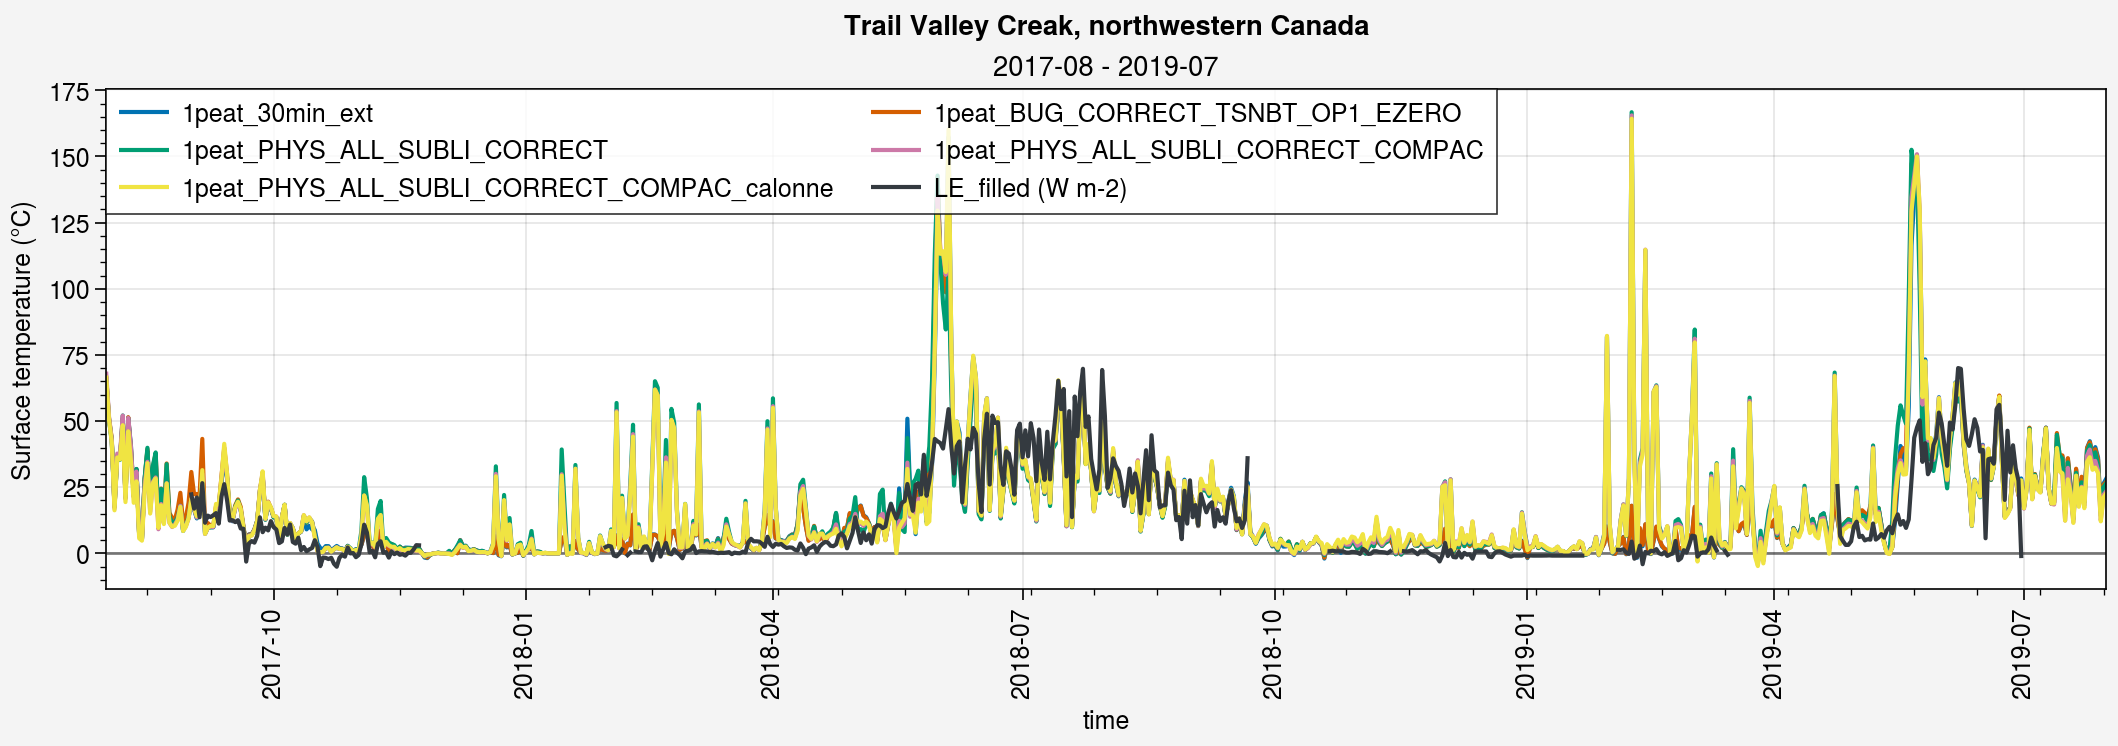

In [144]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.hfls.sel(time=period), label=label)
    
    # Obs
    axs[0].plot(ds_d_obs.LE_filled.sel(time=period), color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)


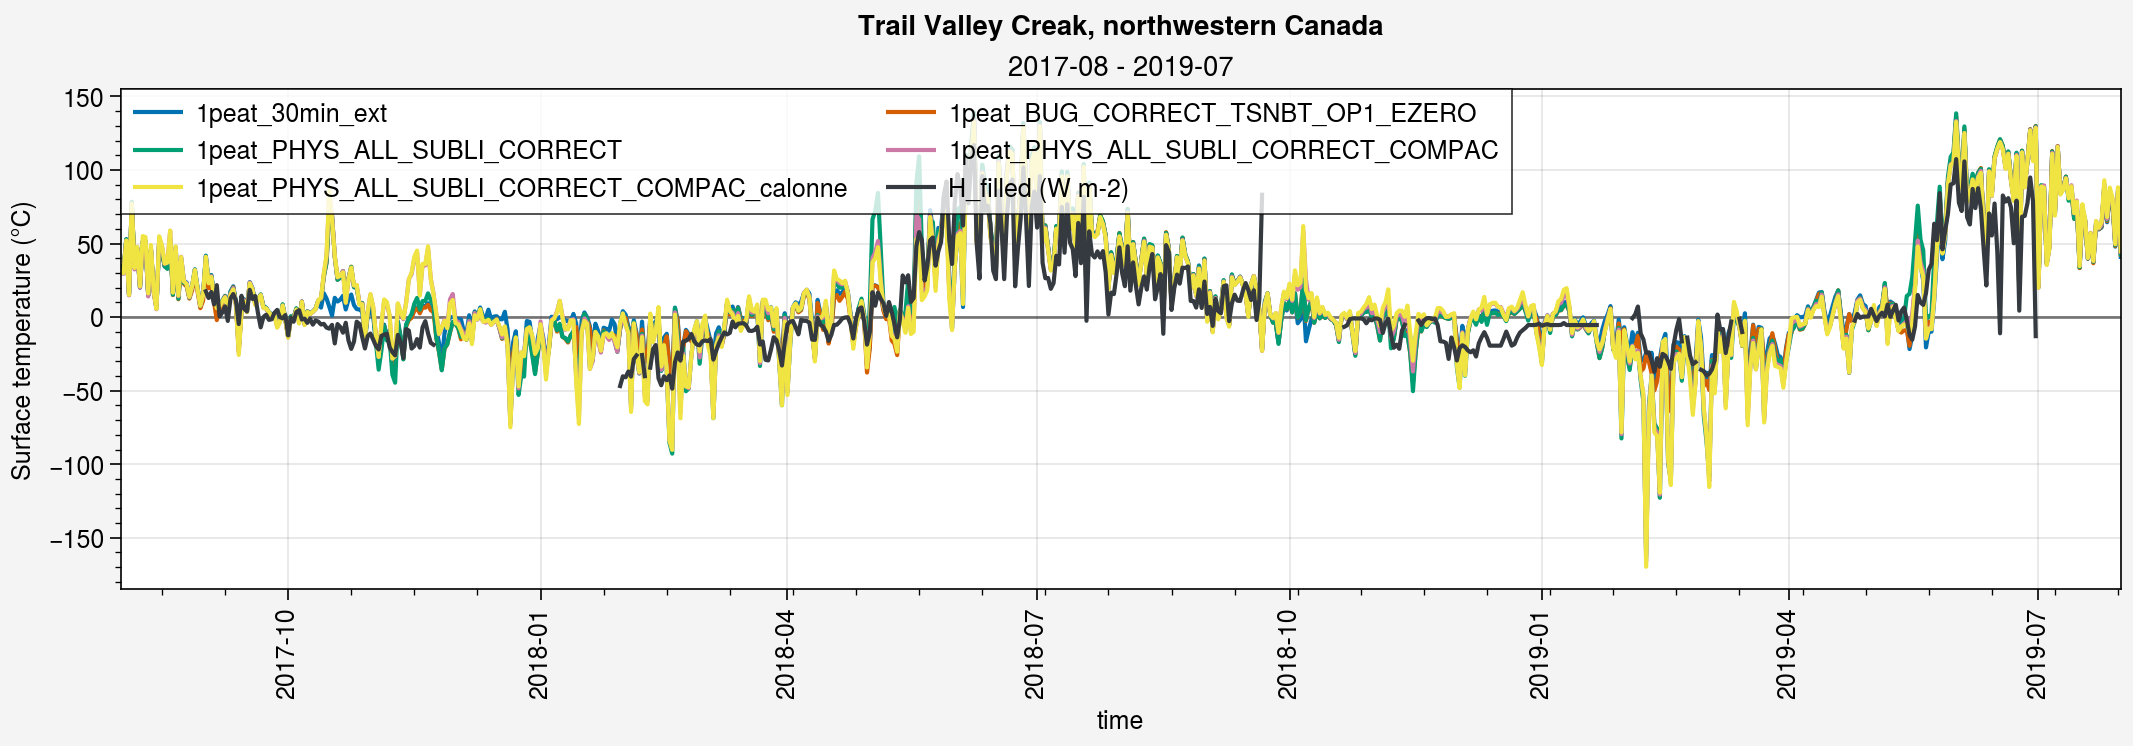

In [145]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.hfss.sel(time=period), label=label)
    
    # Obs
    axs[0].plot(ds_d_obs.H_filled.sel(time=period), color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)


In [146]:
ds_d.npp

<xarray.DataArray 'npp' (time: 2555)> Size: 20kB
array([-2.37432476e-10, -2.46092231e-10, -2.50295033e-10, ...,
       -1.73955212e-11, -2.33887904e-11, -2.66754600e-11])
Coordinates:
  * time     (time) datetime64[ns] 20kB 2013-01-01 2013-01-02 ... 2019-12-31
Attributes:
    long_name:   Carbon Mass Flux out of Atmosphere due to Net Primary Produc...
    units:       kg m$^{-2}$ s$^{-1}$
    nameInCode:  npp_d_g

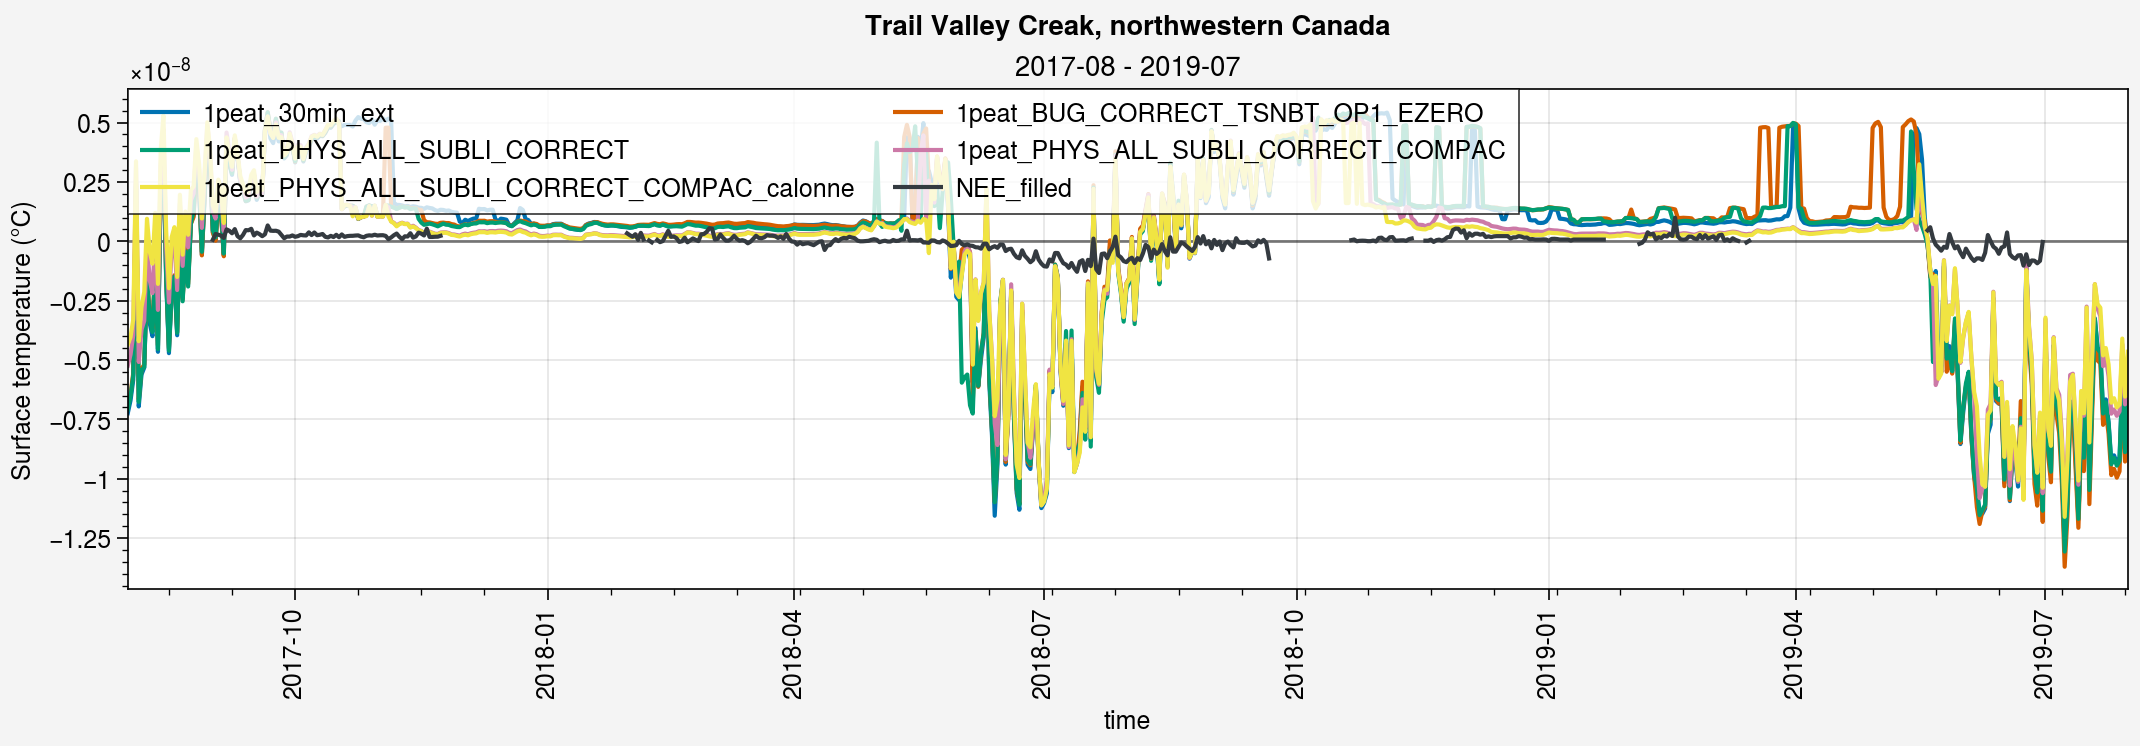

In [147]:
%matplotlib inline
gap = 2
color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-08',str(years[i*gap+gap])+'-07')
    else:
        period=slice(str(years[i*gap])+'-08',str(years[-1])+'-07')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(-ds_d.nep.sel(time=period), label=label)
    
    # Obs
    axs[0].plot(ds_d_obs.NEE_filled.sel(time=period)*4.401e-10, color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)
